1-analyse.ipynb 

# **En komparativ studie av GPT-4 og legers svar på helserelaterte spørsmål** 

Tiril Egset Mork¹, Håkon Garnes Mjøs¹, Harald Giskegjerde Nilsen², Sindre Kjelsrud², Alexander Selvikvåg Lundervold³, Arvid Lundervold⁴, Ib Jammer⁵ <br>

¹ Det medisinske fakultet, Universitetet i Bergen <br>
² Høgskulen på Vestlandet<br>
³ Institutt for datateknologi, elektroteknologi og realfag, Høgskulen på Vestlandet<br>
⁴ Institutt for biomedisin, Universitetet i Bergen<br>
⁵ Kirurgisk serviceklinikk, Haukeland universitetssykehus (ib.jammer@helse-bergen.no)


Last updated: 2024-10-09 (A.L.)

Using the `helseveileder` conda environment for this notebook.

### Hypotesene som undersøkes er følgende:

**Kunnskapsnivå** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

**Empati** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

**Hjelpsomhet** :<br>
H0: Chat-GPT 4.0 genererer _samme_ grad av hjelpsomme svar på kliniske spørsmål, sammenlignet med leger.<br>
H1: Chat-GPT 4.0 genererer _forskjellig_ grad av hjelpsomme svar på kliniske spørsmål sammenlignet med leger (trolig _mindre_ hjelpsomhet).


Oversikt over materialet:

| Beskrivelse | Verdi |
|-------------|-------|
| Totalt antall spørsmål (hvert med to svar til vurdering) | 192 |
| Totalt antall respondenter | 355 |
| Totalt antall responser (vurderinger av sett med spørsmål og svar) | 2287 |
| Gjennomsnittlig antall responser per spørsmål | 11.9 |
| Median antall respondenser per spørsmål | 10 |
| Antall som har deltatt i studien mer enn en gang | 19 (5.4%) |
| Antall respondenter som oppgir å være lege eller medisinstudent med lisens. | 44 (12.4%) |
| Antall respondenter som ikke er lege eller medisinstudent med lisens, men som studerer, arbeider eller har bakgrunn innen helsevesenet | 298 (83.9%) |
| Median (range) lengde på spørsmål | 102 (8-200) ord |
| Median (range svarlengde legesvar (1142 vurderinger) | 115 (39-408) ord |
| Median (range) svarlengde GPT-4 (1145 vurderinger) | 204 (130-347) ord |

# Oppsett / biblioteker

In [1]:
%matplotlib inline
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu 

# Les inn data
`helseveileder_2287x18.csv`

In [2]:
df = pd.read_csv('../data/helseveileder_2287x18.csv')
len(df)

2287

In [3]:
list(df.columns)

['vurderingid',
 'respondentid',
 'svarid',
 'kunnskap',
 'empati',
 'hjelpsomhet',
 'alder',
 'utdanningsgrad',
 'helsepersonell',
 'harlisens',
 'kjønn',
 'svartfør',
 'fylke',
 'dato',
 'spørsmålid',
 'chatgpt',
 'svartekst',
 'tekst']

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2287 entries, 0 to 2286
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   vurderingid     2287 non-null   int64 
 1   respondentid    2287 non-null   int64 
 2   svarid          2287 non-null   int64 
 3   kunnskap        2287 non-null   int64 
 4   empati          2287 non-null   int64 
 5   hjelpsomhet     2287 non-null   int64 
 6   alder           2259 non-null   object
 7   utdanningsgrad  2287 non-null   object
 8   helsepersonell  2287 non-null   bool  
 9   harlisens       2287 non-null   bool  
 10  kjønn           2267 non-null   object
 11  svartfør        2287 non-null   bool  
 12  fylke           2285 non-null   object
 13  dato            2287 non-null   object
 14  spørsmålid      2287 non-null   int64 
 15  chatgpt         2287 non-null   bool  
 16  svartekst       2287 non-null   object
 17  tekst           2287 non-null   object
dtypes: bool(

In [5]:
# Make a dataframe dmeta with the metadata (col-number, col-name, data-type, number-of-nans, min, max) of the dataframe df

# Create a list of column numbers
col_numbers = range(len(df.columns)+1)[1:]

# Create a list of column names
col_names = df.columns

# Create a list of column data types
col_dtypes = df.dtypes

# Create a list of column number of NaNs
col_nans = df.isna().sum()

# Create a list of column minimum values excluding NaN
def min_of_each_column(df):
    return df.apply(lambda col: col.dropna().min())
col_min = min_of_each_column(df)

# Create a list of column maximum values
def max_of_each_column(df):
    return df.apply(lambda col: col.dropna().max())
col_max = max_of_each_column(df)

# Create a dataframe dmeta with the metadata
dmeta = pd.DataFrame({'col_number': col_numbers, 'col_name': col_names, 'col_dtype': col_dtypes, 'col_nans': col_nans, 'col_min': col_min, 'col_max': col_max})

# Reset the index of the dataframe dmeta
dmeta.reset_index(drop=True, inplace=True)

# Display the dataframe dmeta
dmeta

,col_number,col_name,col_dtype,col_nans,col_min,col_max
0,1,vurderingid,int64,0,1,2304
1,2,respondentid,int64,0,3,638
2,3,svarid,int64,0,1,393
3,4,kunnskap,int64,0,1,6
4,5,empati,int64,0,1,5
5,6,hjelpsomhet,int64,0,1,5
6,7,alder,object,28,18-20,71+
7,8,utdanningsgrad,object,0,Bachelor,VGS
8,9,helsepersonell,bool,0,False,True
9,10,harlisens,bool,0,False,True


In [6]:
df


,vurderingid,respondentid,svarid,kunnskap,empati,hjelpsomhet,alder,utdanningsgrad,helsepersonell,harlisens,kjønn,svartfør,fylke,dato,spørsmålid,chatgpt,svartekst,tekst
0,1,6,1,3,4,4,18-20,PhD,True,False,Kvinne,False,Vestland,2024-01-15T10:39:13.805Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
1,4,7,1,2,4,3,18-20,PhD,True,False,Kvinne,False,Vestland,2024-01-15T10:39:27.752Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
2,8,8,1,5,4,5,20-30,PhD,True,False,Mann,False,Vestland,2024-01-15T10:39:52.900Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
3,13,3,1,5,4,4,20-30,PhD,True,False,Mann,False,Vestland,2024-01-15T10:38:43.709Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
4,1722,542,1,2,4,4,NaN,VGS,True,False,Kvinne,False,Vestland,2024-01-30T07:19:38.401Z,1,False,Takk for spørsmålet ditt! Jeg skal være ærlig ...,Hei! Jeg har jo hørt at sånn belegg som var i ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,2253,634,390,5,2,4,21-30,VGS,True,False,Kvinne,True,Vestland,2024-02-14T07:29:01.729Z,238,False,Det er nok ikke vanlig rutine å gi full narkos...,Hei! Vet ikke om det mulig å få riktig svar he...
2283,2263,635,390,3,2,3,21-30,Bachelor,True,False,Kvinne,True,Vestland,2024-02-14T07:32:31.629Z,238,False,Det er nok ikke vanlig rutine å gi full narkos...,Hei! Vet ikke om det mulig å få riktig svar he...
2284,2255,634,393,5,5,4,21-30,VGS,True,False,Kvinne,True,Vestland,2024-02-14T07:29:01.729Z,239,True,Hei! Det å drikke 3-4 glass vann etter hverand...,Hei! Jeg drakk ganske mye vann en natt av ulik...
2285,2265,635,393,4,4,4,21-30,Bachelor,True,False,Kvinne,True,Vestland,2024-02-14T07:32:31.629Z,239,True,Hei! Det å drikke 3-4 glass vann etter hverand...,Hei! Jeg drakk ganske mye vann en natt av ulik...


In [7]:
# Calculate values
total_questions = len(df['spørsmålid'].unique())
total_respondents = len(df['respondentid'].unique())
total_responses = len(df)
avg_responses_per_question = total_responses / total_questions
median_responses_per_question = df.groupby('spørsmålid').size().median()

# Count respondents who participated more than once
repeat_participants = df.groupby('respondentid').size()
repeat_participants = repeat_participants[repeat_participants > 1]
repeat_count = len(repeat_participants)
repeat_percentage = (repeat_count / total_respondents) * 100

# Count respondents by type
licensed_doctors = df[df['harlisens'] == True]['respondentid'].nunique()
licensed_percentage = (licensed_doctors / total_respondents) * 100

health_background = df[(df['helsepersonell'] == True) & (df['harlisens'] == False)]['respondentid'].nunique()
health_background_percentage = (health_background / total_respondents) * 100

# Calculate question and answer lengths
question_lengths = df.groupby('spørsmålid')['tekst'].first().str.split().str.len()
human_answer_lengths = df[df['chatgpt'] == False]['svartekst'].str.split().str.len()
gpt_answer_lengths = df[df['chatgpt'] == True]['svartekst'].str.split().str.len()

# Create the table
table = pd.DataFrame({
    'Beskrivelse': [
        'Totalt antall spørsmål (hvert med to svar til vurdering)',
        'Totalt antall respondenter',
        'Totalt antall responser (vurderinger av sett med spørsmål og svar)',
        'Gjennomsnittlig antall responser per spørsmål',
        'Median antall respondenser per spørsmål',
        'Antall som har deltatt i studien mer enn en gang',
        'Antall respondenter som oppgir å være lege eller medisinstudent med lisens.',
        'Antall respondenter som ikke er lege eller medisinstudent med lisens, men som studerer, arbeider eller har bakgrunn innen helsevesenet',
        'Median (range) lengde på spørsmål',
        'Median (range svarlengde legesvar (1142 vurderinger)',
        'Median (range) svarlengde GPT-4 (1145 vurderinger)'
    ],
    'Verdi': [
        f"{total_questions}",
        f"{total_respondents}",
        f"{total_responses}",
        f"{avg_responses_per_question:.1f}",
        f"{median_responses_per_question}",
        f"{repeat_count} ({repeat_percentage:.1f}%)",
        f"{licensed_doctors} ({licensed_percentage:.1f}%)",
        f"{health_background} ({health_background_percentage:.1f}%)",
        f"{question_lengths.median()} ({question_lengths.min()}-{question_lengths.max()}) ord",
        f"{human_answer_lengths.median()} ({human_answer_lengths.min()}-{human_answer_lengths.max()}) ord",
        f"{gpt_answer_lengths.median()} ({gpt_answer_lengths.min()}-{gpt_answer_lengths.max()}) ord"
    ]
})

print(table.to_string(index=False))

                                                                                                                           Beskrivelse               Verdi
                                                                              Totalt antall spørsmål (hvert med to svar til vurdering)                 192
                                                                                                            Totalt antall respondenter                 355
                                                                    Totalt antall responser (vurderinger av sett med spørsmål og svar)                2287
                                                                                         Gjennomsnittlig antall responser per spørsmål                11.9
                                                                                               Median antall respondenser per spørsmål                10.0
                                                                      

Antall GPT-4 svar: 1145, Antall legesvar:1142. Totalt: 2287


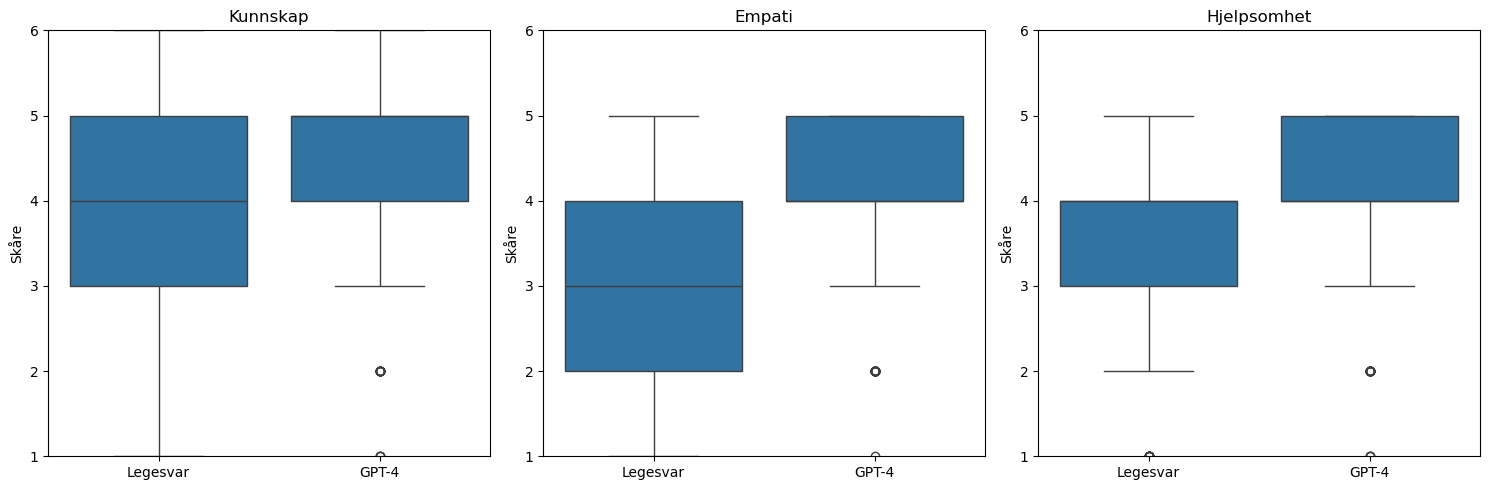

In [8]:
df_GPT = df[df['chatgpt'] == True]
df_human = df[df['chatgpt'] == False]

print(f'Antall GPT-4 svar: {len(df_GPT)}, Antall legesvar:{len(df_human)}. Totalt: {len(df_GPT) + len(df_human)}')

# Make a boxplot to compare the GPT and human responses for `kunnskap', 'empati` and 'hjelpsomhet'

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Custom order and labels for x-axis
order = [False, True]
labels = ['Legesvar', 'GPT-4']

for i, metric in enumerate(['kunnskap', 'empati', 'hjelpsomhet']):
    sns.boxplot(x='chatgpt', y=metric, data=df, ax=ax[i], order=order)
    ax[i].set_xticks([0, 1])
    ax[i].set_xticklabels(labels)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Skåre')
    ax[i].set_title(metric.capitalize())
    ax[i].set_ylim(1, 6)

plt.tight_layout()

### Hypotese 1 som undersøkes (mhp. df) er følgende:

**Kunnskapsnivå** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål på _samme_ kunnskapsnivå, sammenlignet svar fra utdannede og lisensierte leger (MDs).<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _forskjellig_ kunnskapsnivå sammenlignet med leger (trolig _lavere_ kunnskapsnivå).

For å teste denne hypotesen kan vi bruke en statistisk test. Gitt at vi har ordinale data (Likert-skala vurderinger) og to uavhengige grupper (GPT-4 og leger),
er **Mann-Whitney U-testen** en passende metode. Her er hvordan du kan implementere dette i Python:

In [9]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['kunnskap'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['kunnskap'], margins=True)
contingency_table_margins

kunnskap,1,2,3,4,5,6,All
chatgpt,,,,,,,
False,6,83,241,486,271,55,1142
True,3,20,87,442,542,51,1145
All,9,103,328,928,813,106,2287


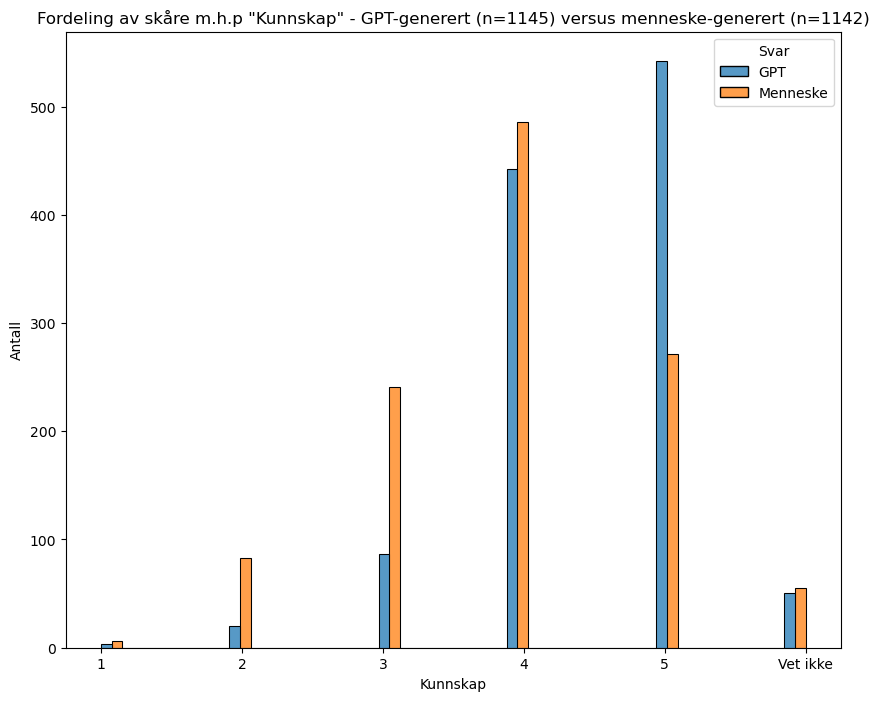

In [10]:
# Plot the distribution of the scores for "kunnskap" - GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['kunnskap']].assign(Svar='GPT'), df_human[['kunnskap']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Svar', multiple='dodge')

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Kunnskap" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(6)

# Replace the label at the index with 'Vet ikke'
labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

#### Ignorér "`Vet ikke`" (skåre 6) vedrørende `kunnskap` i forbindesle med Mann-Whitney U test og  Chi-kvadrat test

In [11]:
# Make new dataframes df_GPT_kunsskap_excl6 and df_human_kunnskap_excl6 where kunnskap is not 6

df_GPT_kunnskap_excl6 = df_GPT[df_GPT['kunnskap'] != 6]
df_human_kunnskap_excl6 = df_human[df_human['kunnskap'] != 6]

print(f'len(df_GPT_kunnskap_excl6)={len(df_GPT_kunnskap_excl6)}, len(df_human_kunnskap_excl6)={len(df_human_kunnskap_excl6)}')


len(df_GPT_kunnskap_excl6)=1094, len(df_human_kunnskap_excl6)=1087


In [12]:
df1 = df.copy()
# Convert 'kunnskap' to numeric, coercing errors to NaN
df1['kunnskap'] = pd.to_numeric(df1['kunnskap'], errors='coerce')

# Remove rows with NaN values in 'kunnskap'
df1 = df1.dropna(subset=['kunnskap'])

# Remove rows with value 6 ("vet ikke") in 'kunnskap'
df1 = df1[df1['kunnskap'] != 6]

# Ensure 'chatgpt' is boolean
df['chatgpt'] = df['chatgpt'].astype(bool)

# Now proceed with the analysis
gpt_scores = df1[df1['chatgpt'] == True]['kunnskap']
human_scores = df1[df1['chatgpt'] == False]['kunnskap']

stat=788164.5, p=2.4010337081210183e-45
Forskjellig fordeling (forkast H0)
($n_{GPT-4}$ = 1094, $n_{legesvar}$ = 1087)
Median knowledge score for GPT-4: 4.0
Median knowledge score for humans: 4.0


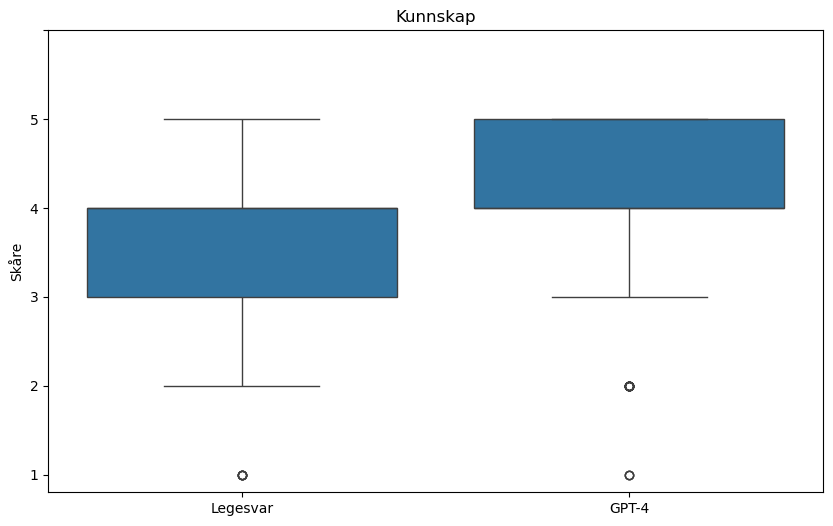

In [13]:
# Test the following hypothesis: H0: The distribution of the scores for kunnskap for GPT and human are the same 
# vs. H1: The distribution of the scores of kunnskap for GPT and human are different (human scores are likely higher)

# Perform the Mann-Whitney U test
# stat, p = mannwhitneyu(df_GPT_kunnskap_excl6['kunnskap'], df_human_kunnskap_excl6['kunnskap'])
stat, p = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT-4}}$ = {len(gpt_scores)}, $n_{{legesvar}}$ = {len(human_scores)})')
# Calculate and print medians for both groups
print(f"Median knowledge score for GPT-4: {gpt_scores.median()}")
print(f"Median knowledge score for humans: {human_scores.median()}")

# Make a boxplot to compare the GPT and human responses for `kunnskap`

# Custom order and labels for x-axis
order = [False, True]
labels = ['Legesvar', 'GPT-4']
labels_y = ['1', '2', '3', '4', '5', ' ']

fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(x='chatgpt', y='kunnskap', data=df1, ax=ax)
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)
ax.set_xlabel('')
ax.set_title('Kunnskap')
ax.set_yticks(range(1, 7))
ax.set_yticklabels(labels_y)
ax.set_ylabel('Skåre')
plt.show()


Forklaring av disse resultatene i detalj:

1. Statistisk test:
   Disse resultatene kommer fra en Mann-Whitney U-test, som brukes for å sammenligne fordelingene av to uavhengige grupper (i dette tilfellet, GPT-4 svar og menneskelige svar) når dataene er ordinale (som Likert-skala vurderinger).

2. Teststatistikk (stat):
   - stat = 788164.5
   - Dette er U-statistikken fra Mann-Whitney testen.
   - U-statistikken representerer graden av overlapp mellom de to gruppene. En høyere U-verdi indikerer større forskjell mellom gruppene.

3. p-verdi:
   - p = 2.4010337081210183e-45
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0.05 eller 0.01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem teststatistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell mellom gruppene ved en tilfeldighet.

4. Tolkning:
   "Forskjellig fordeling (forkast H0)"
   - Dette betyr at vi forkaster nullhypotesen (H0) om at fordelingene av kunnskapsvurderinger for GPT-4 og menneskelige svar er like.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en signifikant forskjell i kunnskapsnivå mellom GPT-4 svar og menneskelige svar.

5. Utvalgsstørrelser:
   - n_GPT = 1094: Antall vurderinger av GPT-4 svar
   - n_human = 1087: Antall vurderinger av menneskelige svar
   - Disse tallene viser at vi har et stort og balansert utvalg, noe som øker påliteligheten av resultatene.

6. Praktisk betydning:
   - Selv om testen viser en statistisk signifikant forskjell, forteller den ikke direkte om retningen eller størrelsen på forskjellen.
   - For å forstå retningen (om GPT-4 ble vurdert som mer eller mindre kunnskapsrik), må vi se på sentrale tendenser (f.eks. median eller gjennomsnitt) for hver gruppe.
   - Størrelsen på effekten (hvor stor forskjellen er i praksis) bør vurderes separat, for eksempel ved å beregne effektstørrelse.

7. Begrensninger:
   - Testen sier ingenting om nøyaktigheten eller kvaliteten på kunnskapen, bare hvordan den ble oppfattet av vurdererne.
   - Andre faktorer som kan påvirke vurderingene (f.eks. svarenes lengde eller struktur) bør også vurderes.

Konklusjon:
Resultatene gir sterk statistisk evidens for at det er en forskjell i hvordan kunnskapsnivået i GPT-4 svar og menneskelige svar ble vurdert. Gitt den ekstremt lave p-verdien, er denne forskjellen høyst sannsynlig ikke et resultat av tilfeldigheter. Videre analyse av sentrale tendenser og effektstørrelser vil gi mer innsikt i naturen og omfanget av denne forskjellen.

In [14]:
# How large is the difference in the mean scores of kunnskap for GPT and human?

mean_GPT = df_GPT_kunnskap_excl6['kunnskap'].mean()
mean_human = df_human_kunnskap_excl6['kunnskap'].mean()

std_GPT = df_GPT['kunnskap'].std()
std_human = df_human['kunnskap'].std()

diff = mean_GPT - mean_human
print(f'Mean score for kunnskap for GPT-4: {mean_GPT:.2f} ± {std_GPT:.2f} (n={len(df_GPT_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Mean score for kunnskap for human: {mean_human:.2f} ± {std_human:.2f} (n={len(df_human_kunnskap_excl6)}) (excluding "Vet ikke")')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for kunnskap for GPT-4: 4.37 ± 0.79 (n=1094) (excluding "Vet ikke")
Mean score for kunnskap for human: 3.86 ± 0.99 (n=1087) (excluding "Vet ikke")
Difference in mean scores: 0.51


#### Kjikvadrat test

In [15]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df1['chatgpt'], df1['kunnskap'])

contingency_table_margins = pd.crosstab(df1['chatgpt'], df1['kunnskap'], margins=True)
contingency_table_margins

kunnskap,1,2,3,4,5,All
chatgpt,,,,,,
False,6,83,241,486,271,1087
True,3,20,87,442,542,1094
All,9,103,328,928,813,2181


In [16]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.")

Chi-square statistic: 204.23803598480472
p-value: 4.609064195655399e-43
Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors.


Vurdering av resultatene i detalj:

1. Statistisk test:
   Disse resultatene kommer fra en chi-kvadrat test (χ²-test). Denne testen brukes for å sammenligne fordelingen av kategoriske variabler mellom to eller flere uavhengige grupper. I dette tilfellet sammenligner vi fordelingen av kunnskapsskårer mellom Chat-GPT 4.0 og lisensierte leger.

2. Chi-kvadrat statistikk:
   - Chi-square statistic: 204.23803598480472
   - Dette er den beregnede χ²-verdien fra testen.
   - Denne verdien kvantifiserer hvor mye de observerte frekvensene avviker fra de forventede frekvensene under nullhypotesen.
   - En høyere χ²-verdi indikerer en større forskjell mellom de observerte og forventede frekvensene.

3. p-verdi:
   - p-value: 4.609064195655399e-43
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0.05 eller 0.01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem χ²-statistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell i fordelingen av kunnskapsskårer ved en tilfeldighet.

4. Tolkning:
   "Reject H0: There is a significant difference in the distribution of knowledge scores between Chat-GPT 4.0 and licensed doctors."
   - Dette betyr at vi forkaster nullhypotesen (H0) om at fordelingen av kunnskapsskårer er lik for Chat-GPT 4.0 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en signifikant forskjell i fordelingen av kunnskapsskårer mellom de to gruppene.

5. Praktisk betydning:
   - Resultatene viser at det er en statistisk signifikant forskjell i hvordan kunnskapsskårene er fordelt mellom Chat-GPT 4.0 og lisensierte leger.
   - Dette betyr at mønsteret i kunnskapsvurderingene er forskjellig for de to gruppene. For eksempel kan en gruppe ha en tendens til å få flere høye skårer, mens den andre gruppen kan ha en mer jevn fordeling.
   - Merk at testen ikke forteller oss hvilken gruppe som presterer bedre, bare at fordelingene er forskjellige.

6. Begrensninger og videre analyse:
   - Chi-kvadrat testen forteller oss at det er en forskjell, men ikke hvordan fordelingene er forskjellige.
   - For å forstå naturen av forskjellen, bør man undersøke de faktiske fordelingene, for eksempel gjennom visualiseringer eller ved å se på spesifikke prosentandeler for hver skårkategori.
   - Testen sier ingenting om kvaliteten eller nøyaktigheten av kunnskapen, bare om hvordan skårene er fordelt.

7. Implikasjoner:
   - Disse resultatene antyder at Chat-GPT 4.0 og lisensierte leger vurderes forskjellig når det gjelder kunnskapsnivå i denne konteksten.
   - Dette kan ha implikasjoner for hvordan AI-systemer som Chat-GPT 4.0 kan brukes i medisinske sammenhenger, og hvordan deres ytelse sammenlignes med menneskelige eksperter.

Konklusjon:
Chi-kvadrat testen gir sterk statistisk evidens for at det er en forskjell i fordelingen av kunnskapsskårer mellom Chat-GPT 4.0 og lisensierte leger. Gitt den ekstremt lave p-verdien, er denne forskjellen høyst sannsynlig ikke et resultat av tilfeldigheter. Videre analyse er nødvendig for å forstå den spesifikke naturen av denne forskjellen og dens praktiske implikasjoner.

Følgende analyser vil hjelpe i tolkningen av disse resultatene:

1. Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT-4 og menneskelige svar.
2. Identifisere hvilke skåre-kategorier som bidrar mest til den totale forskjellen.
3. Utforske hvordan ulike respondentfaktorer kan påvirke oppfatningen av kunnskap i GPT-4 vs. menneskelige svar.
4. Statistisk teste om disse faktorene signifikant påvirker forholdet mellom svartype (GPT-4/menneskelige svar) og oppfattet kunnskap.

Husk å tolke disse resultatene i konteksten av studien og vurder eventuelle begrensninger eller potensielle skjevheter i datainnsamlings- eller analysemetodene.

 Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT-4 og menneskelige svar

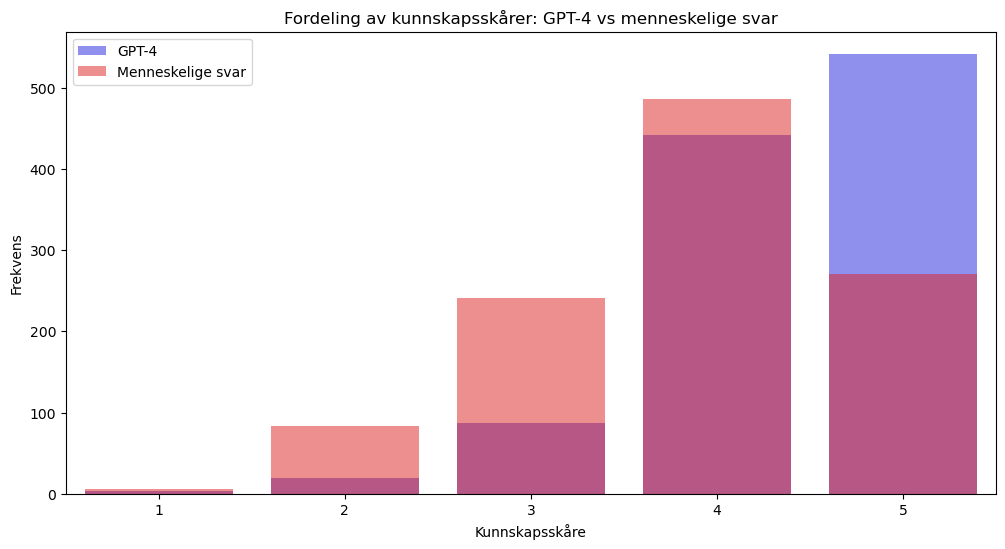

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df1[df1['chatgpt'] == True]['kunnskap'].value_counts().sort_index()
human_freq = df1[df1['chatgpt'] == False]['kunnskap'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT-4')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Menneskelige svar')
plt.title('Fordeling av kunnskapsskårer: GPT-4 vs menneskelige svar')
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

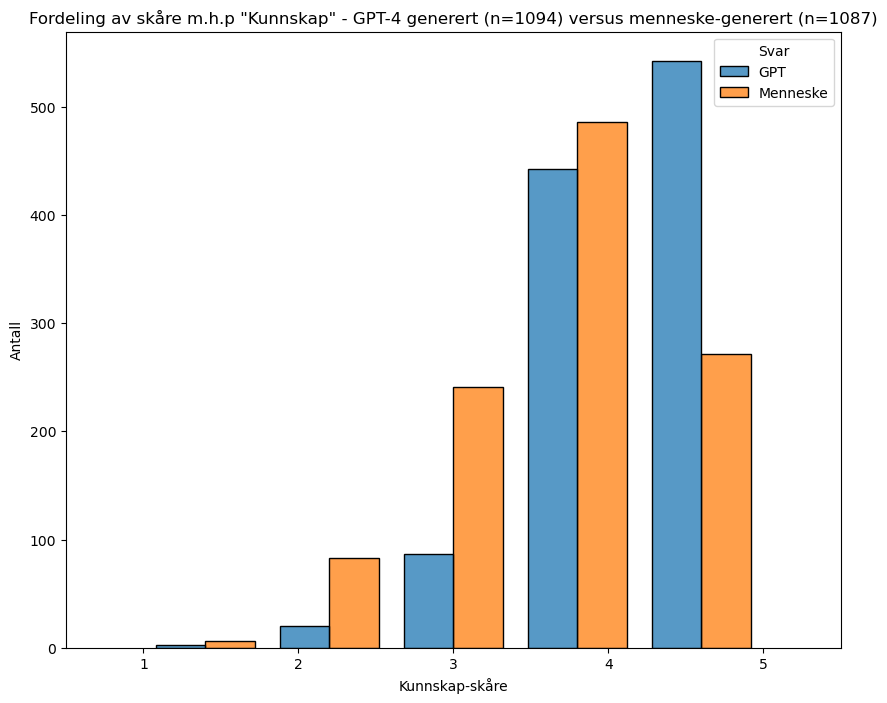

In [18]:
# Plot the distribution of the scores for "kunnskap" - GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

df1_GPT = df1[df1['chatgpt'] == True]
df1_human = df1[df1['chatgpt'] == False]

# Combine the data into a single DataFrame
df1_combined = pd.concat([df1_GPT[['kunnskap']].assign(Svar='GPT'), df1_human[['kunnskap']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df1_combined, x='kunnskap', hue='Svar', multiple='dodge', binwidth=0.8, shrink=0.8)

# Make the bars wider
# Center the bars on the tick marks


plt.xlabel('Kunnskap-skåre')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Kunnskap" - GPT-4 generert (n={len(df1_GPT)}) versus menneske-generert (n={len(df1_human)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(5)

# Replace the label at the index with 'Vet ikke'
#labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels

# Adjust the x-axis limits to center the bars on the tick marks
plt.xlim(0.5, 5.5)

plt.show()

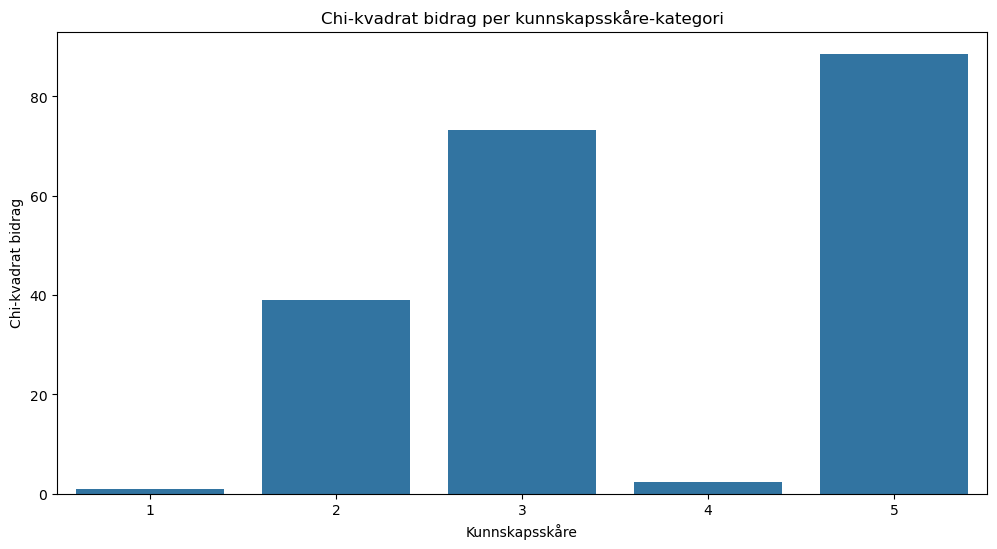

In [19]:
# Calculate the expected frequencies
total = len(df1)
gpt_total = len(df1[df1['chatgpt'] == True])
human_total = len(df1[df1['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-kvadrat bidrag per kunnskapsskåre-kategori')
plt.xlabel('Kunnskapsskåre')
plt.ylabel('Chi-kvadrat bidrag')
plt.show()

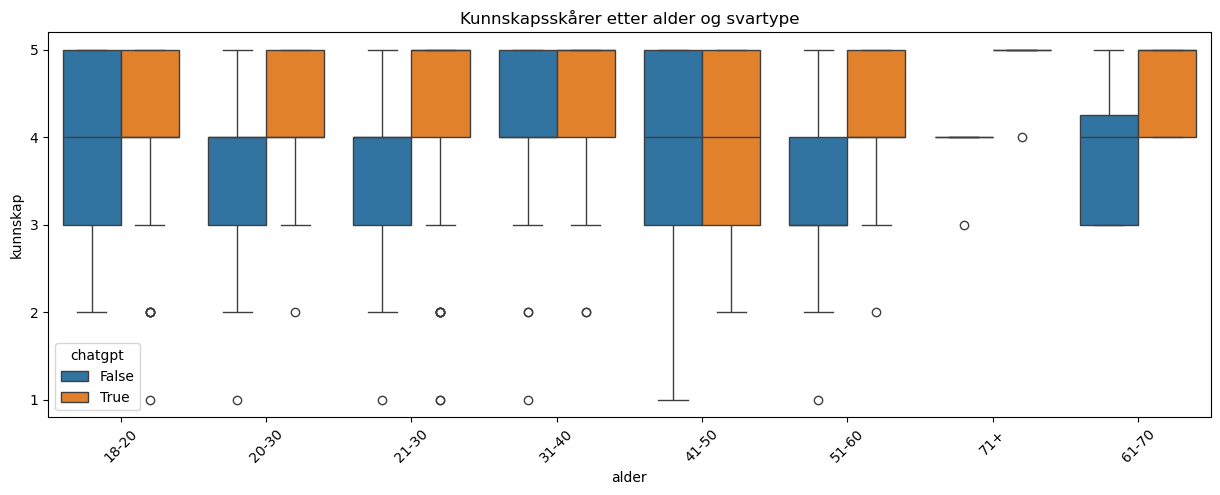

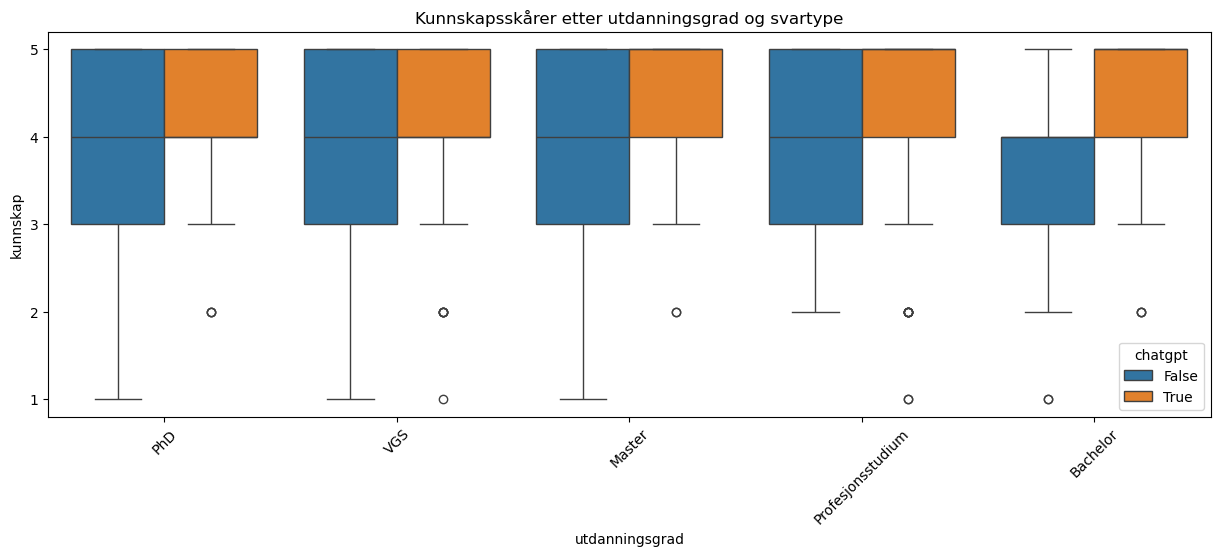

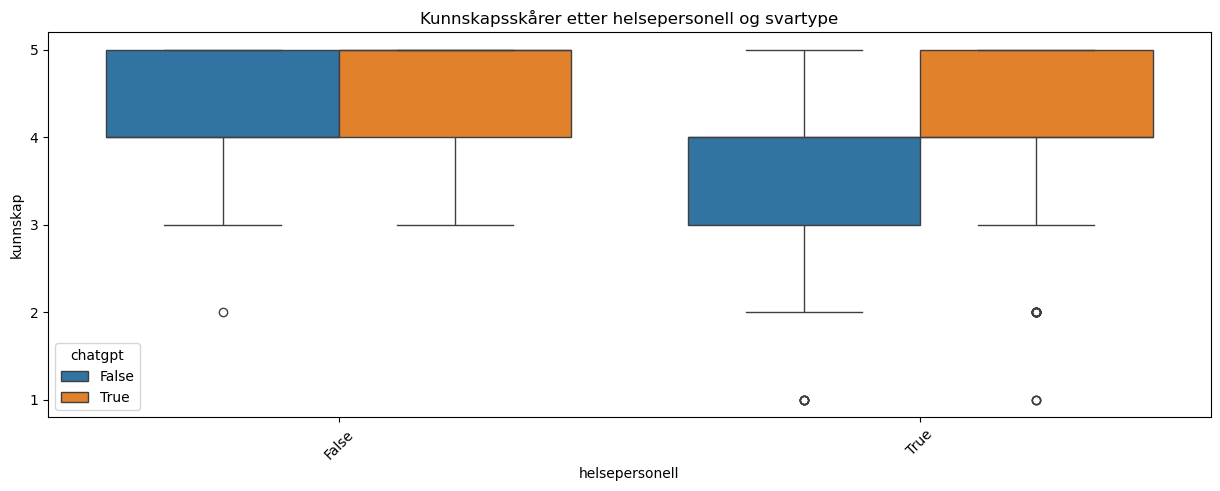

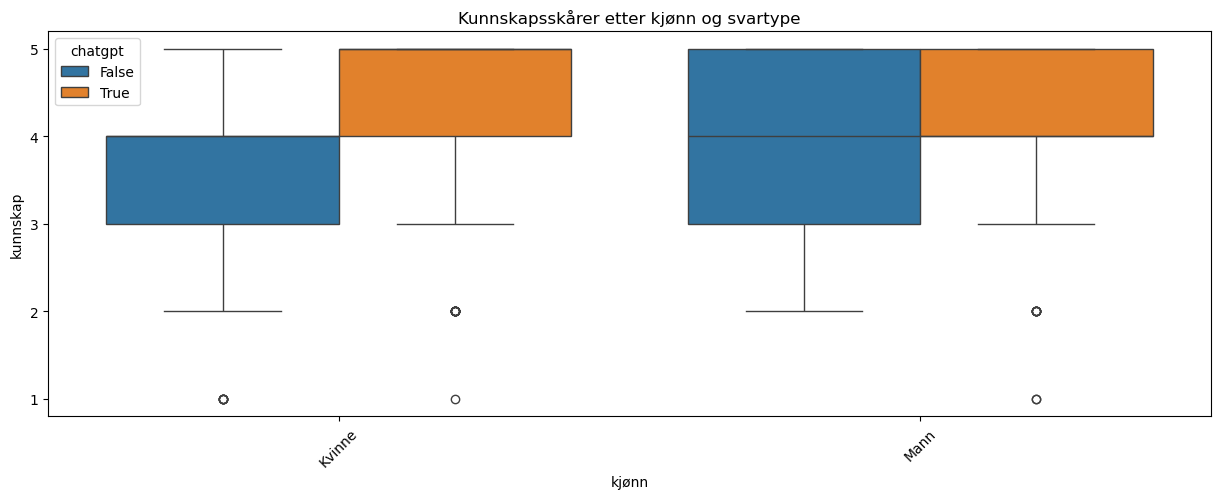

In [20]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='kunnskap', hue='chatgpt', data=df1)
    plt.title(f'Kunnskapsskårer etter {factor} og svartype')
    # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.show()

In [21]:
from scipy.stats import chi2_contingency

def chi_square_test(df1, factor):
    contingency_table = pd.crosstab(df1[factor], [df1['chatgpt'], df1['kunnskap']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-kvadrat test for {factor}:")
    print(f"Chi-kvadrat statistikk: {chi2}")
    print(f"p-verdi: {p}")
    print("---")

for factor in factors:
    chi_square_test(df1, factor)

Chi-kvadrat test for alder:
Chi-kvadrat statistikk: 115.07943832118578
p-verdi: 6.832681539662135e-05
---
Chi-kvadrat test for utdanningsgrad:
Chi-kvadrat statistikk: 68.39222905896085
p-verdi: 0.0008985266328112801
---
Chi-kvadrat test for helsepersonell:
Chi-kvadrat statistikk: 4.028839175063575
p-verdi: 0.909504159621948
---
Chi-kvadrat test for kjønn:
Chi-kvadrat statistikk: 17.382507615236946
p-verdi: 0.043052211953055454
---


Forklaring av resultatene i detalj:

Koden over utfører en chi-kvadrat test for uavhengighet for hver av faktorene (alder, utdanningsgrad, helsepersonell og kjønn) i forhold til chatgpt (om svaret er fra GPT-4 eller menneskelige svar) og kunnskapsnivå. Her er en detaljert forklaring av resultatene:

1. Alder:
   - Chi-kvadrat statistikk: 115.08
   - p-verdi: 6.83e-05
   Dette indikerer en statistisk signifikant sammenheng mellom alder og fordelingen av kunnskapsskårer for GPT vs. menneskelige svar. Den svært lave p-verdien tyder på at denne sammenhengen er høyst usannsynlig å være et resultat av tilfeldigheter.

2. Utdanningsgrad:
   - Chi-kvadrat statistikk: 68.39
   - p-verdi: 0.0009
   Dette viser også en signifikant sammenheng mellom utdanningsnivå og fordelingen av kunnskapsskårer. P-verdien er under 0.05, noe som indikerer at sammenhengen er statistisk signifikant.

3. Helsepersonell:
   - Chi-kvadrat statistikk: 4.03
   - p-verdi: 0.91
   Her ser vi ingen signifikant sammenheng. Den høye p-verdien (0.91) antyder at det å være helsepersonell eller ikke ikke har en betydelig innvirkning på hvordan kunnskapsskårene er fordelt mellom GPT og menneskelige svar.

4. Kjønn:
   - Chi-kvadrat statistikk: 17.38
   - p-verdi: 0.043
   Dette resultatet viser en svak, men statistisk signifikant sammenheng mellom kjønn og fordelingen av kunnskapsskårer. P-verdien er like under 0.05, noe som indikerer en marginal signifikans.

Tolkning:
1. Alder og utdanningsgrad ser ut til å ha en sterk innflytelse på hvordan folk vurderer kunnskapsnivået i svar fra GPT vs. mennesker. Dette kan bety at ulike aldersgrupper og folk med ulik utdanningsbakgrunn oppfatter eller evaluerer AI-genererte svar forskjellig fra menneskelige svar.

2. Hvorvidt noen er helsepersonell eller ikke ser ikke ut til å påvirke hvordan de vurderer kunnskapsnivået i svarene. Dette er interessant og kan tyde på at AI-genererte svar oppfattes likt av både helsepersonell og ikke-helsepersonell.

3. Kjønn har en svak, men merkbar effekt på vurderingen av kunnskapsnivå. Dette kan indikere små forskjeller i hvordan menn og kvinner oppfatter eller evaluerer svarene.

Begrensninger og videre betraktninger:
- Disse testene viser bare om det er en sammenheng, ikke styrken eller retningen på sammenhengen.
- Andre faktorer som ikke er inkludert i denne analysen kan også spille en rolle.
- Det er viktig å vurdere den praktiske betydningen av disse funnene, ikke bare den statistiske signifikansen.

Disse resultatene gir verdifull innsikt i hvordan ulike demografiske faktorer kan påvirke oppfatningen av AI-genererte vs. menneskelige svar i en medisinsk kontekst.

### Empati: Hypotese 2 som undersøkes (mhp. df) er følgende:

**Empati** :<br>
H0: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _samme_ grad av empati, sammenlignet med svar fra leger.<br>
H1: Chat-GPT 4.0 genererer svar på kliniske spørsmål med _ulik_ grad av empati sammenlignet med leger (trolig _mindre_ grad av empati).

In [24]:
from scipy.stats import mannwhitneyu

# Assuming 'df' is your dataframe and it has columns 'chatgpt' (boolean) and 'empati' (empathy score)

# Separate the data into GPT and human responses
gpt_scores = df[df['chatgpt'] == True]['empati']
human_scores = df[df['chatgpt'] == False]['empati']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret results
alpha = 0.05  # Set significance level
if p_value < alpha:
    print("Reject H0: There is a significant difference in empathy level between GPT-4 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in empathy level between GPT-4 and licensed doctors.")

# Calculate and print medians for both groups
print(f"Median empathy score for GPT-4: {gpt_scores.median()}")
print(f"Median empathy score for humans: {human_scores.median()}")
print(f'($n_{{GPT-4}}$ = {len(gpt_scores)}, $n_{{human}}$ = {len(human_scores)})')

Mann-Whitney U statistic: 1008219.0
p-value: 1.107670891790499e-122
Reject H0: There is a significant difference in empathy level between GPT-4 and licensed doctors.
Median empathy score for GPT-4: 4.0
Median empathy score for humans: 3.0
($n_{GPT-4}$ = 1145, $n_{human}$ = 1142)


Her er en detaljert forklaring av resultatene:

1. Mann-Whitney U-statistikk: 1008219,0
   - Dette er den beregnede U-statistikken fra Mann-Whitney U-testen.
   - U-statistikken måler graden av overlapp mellom de to gruppene (GPT-4 og lisensierte leger) når det gjelder empatiskårer.

2. p-verdi: 1,107670891790499e-122
   - Dette er en ekstremt lav p-verdi, langt lavere enn vanlige signifikansnivåer (f.eks. 0,05 eller 0,01).
   - p-verdien representerer sannsynligheten for å observere en like ekstrem eller mer ekstrem teststatistikk, gitt at nullhypotesen er sann.
   - En så lav p-verdi indikerer at det er svært usannsynlig at vi ville observere en slik forskjell mellom gruppene ved en tilfeldighet.

3. Konklusjon: "Forkast H0: Det er en signifikant forskjell i empatinivå mellom GPT-4 og lisensierte leger."
   - Dette betyr at vi avviser nullhypotesen (H0) om at det ikke er noen forskjell i empatinivå mellom GPT-4 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en betydelig forskjell i empatinivå mellom de to gruppene.

4. Median empatiskår:
   - GPT-4: 4,0
   - Mennesker (lisensierte leger): 3,0
   - Dette viser at GPT-4-genererte svar generelt ble vurdert som mer empatiske enn svar fra lisensierte leger.

5. Utvalgsstørrelser:
   - n_GPT-4 = 1145: Antall vurderinger av GPT-4 svar
   - n_human = 1142: Antall vurderinger av svar fra lisensierte leger
   - Disse tallene viser at vi har et stort og balansert utvalg, noe som øker påliteligheten av resultatene.

Detaljert tolkning:
1. Statistisk signifikans: Den ekstremt lave p-verdien indikerer at forskjellen i empatiskårer mellom GPT-4 og lisensierte leger er høyst statistisk signifikant. Dette betyr at den observerte forskjellen er svært usannsynlig å ha oppstått ved en tilfeldighet.

2. Retning av forskjellen: Medianverdiene viser at GPT-4 (4,0) ble vurdert høyere enn lisensierte leger (3,0) når det gjelder oppfattet empati. Dette er et overraskende og potensielt kontroversielt funn, ettersom empati ofte anses som en unikt menneskelig egenskap.

3. Praktisk betydning: Selv om forskjellen er statistisk signifikant, er det viktig å vurdere den praktiske betydningen av denne forskjellen. En forskjell på ett poeng på en Likert-skala er merkbar, spesielt i konteksten av empati i medisinsk kommunikasjon.

4. Mulige forklaringer:
   - GPT-4 kan være programmert til å bruke mer empatisk språk konsekvent.
   - AI-ens svar kan oppfattes som mer pasientsentrerte eller forståelsesfulle.
   - Det kan være en skjevhet i hvordan empati evalueres i skriftlige svar kontra ansikt-til-ansikt-interaksjoner med leger.
   - Spørsmålenes spesifikke natur eller evalueringskriteriene kan favorisere GPT-4s svarstil.

5. Begrensninger:
   - Denne testen måler ikke faktisk empati, bare oppfatningen av empati i skriftlige svar.
   - Den tar ikke hensyn til ikke-verbale signaler eller den dynamiske naturen av menneskelig empati i sanntidsinteraksjoner.
   - Konteksten for spørsmålene og de spesifikke kriteriene for å evaluere empati er avgjørende for å tolke disse resultatene.

Konklusjon:
Resultatene gir sterk statistisk evidens for at GPT-4-genererte svar oppfattes som mer empatiske enn svar fra lisensierte leger i denne studien. Dette funnet utfordrer antakelser om AI-ens evne til å formidle empati sammenlignet med menneskelige helsetjenesteytere. Det reiser viktige spørsmål om hvordan empati oppfattes og evalueres i skriftlig medisinsk kommunikasjon, og kan ha betydelige implikasjoner for bruken av AI i pasientkommunikasjon og støtteroller innen helsevesenet. Videre forskning er nødvendig for å undersøke de spesifikke aspektene ved svarene som oppfattes som empatiske, og hvordan disse resultatene kan variere i muntlige eller ansikt-til-ansikt-interaksjoner mellom pasienter og helsepersonell.

In [25]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['empati'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['empati'], margins=True)
contingency_table_margins

empati,1,2,3,4,5,All
chatgpt,,,,,,
False,47,244,454,317,80,1142
True,1,37,171,595,341,1145
All,48,281,625,912,421,2287


In [26]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.")

Chi-square statistic: 571.2591545282048
p-value: 2.5702284647430944e-122
Reject H0: There is a significant difference in the distribution of empathy scores between GPT-4 and licensed doctors.


Her er en detaljert forklaring av Chi-kvadrat test resultatene:

1. Chi-kvadrat statistikk: 571,2591545282048
   - Dette er den beregnede chi-kvadrat statistikken fra testen.
   - Chi-kvadrat statistikken måler den totale forskjellen mellom de observerte frekvensene og de forventede frekvensene under nullhypotesen.
   - En større chi-kvadrat verdi indikerer en større forskjell mellom de observerte og forventede fordelingene.
   - Denne verdien på 571,26 er ganske stor, noe som tyder på en betydelig forskjell i fordelingene.

2. p-verdi: 2,5702284647430944e-122
   - Dette er en ekstremt lav p-verdi, mye lavere enn vanlige signifikansnivåer (f.eks. 0,05 eller 0,01).
   - p-verdien representerer sannsynligheten for å observere en like stor eller større forskjell i fordelingen av empatiskårer mellom GPT-4 og leger, gitt at det egentlig ikke er noen forskjell.
   - Den ekstremt lave verdien (2,57e-122) antyder at den observerte forskjellen er høyst usannsynlig å oppstå ved en tilfeldighet.

3. Konklusjon: "Forkast H0: Det er en signifikant forskjell i fordelingen av empatiskårer mellom GPT-4 og lisensierte leger."
   - Dette betyr at vi avviser nullhypotesen (H0) om at det ikke er noen forskjell i fordelingen av empatiskårer mellom GPT-4 og lisensierte leger.
   - Vi aksepterer dermed den alternative hypotesen (H1) om at det er en betydelig forskjell i fordelingen av empatiskårer mellom de to gruppene.

Detaljert tolkning:

1. Statistisk signifikans: Den ekstremt lave p-verdien (2,57e-122) indikerer at forskjellen i fordelingen av empatiskårer mellom GPT-4 og leger er høyst statistisk signifikant. Dette betyr at den observerte forskjellen i fordelinger er svært usannsynlig å ha oppstått ved en tilfeldighet.

2. Fordelingens natur: I motsetning til Mann-Whitney U-testen, som sammenligner medianer, sammenligner chi-kvadrat testen hele fordelingen av skårer. Dette betyr at den oppdager forskjeller ikke bare i sentral tendens, men også i spredningen og formen på fordelingene av empatiskårer.

3. Praktisk betydning: Selv om resultatet er statistisk signifikant, er det viktig å vurdere den praktiske betydningen av denne forskjellen. Chi-kvadrat testen forteller oss at fordelingene er forskjellige, men den sier ikke hvordan de er forskjellige eller hvilke skårer som er mer vanlige i hver gruppe.

4. Mulige forklaringer:
   - GPT-4 og legers svar kan bli konsekvent vurdert forskjellig på tvers av spekteret av mulige empatiskårer.
   - Det kan være forskjeller i variabiliteten av empatiskårer mellom GPT-4 og legers svar.
   - Visse empatiskåre-kategorier kan være mer vanlige for en gruppe enn for den andre.

5. Begrensninger:
   - Chi-kvadrat testen gir ikke informasjon om retningen eller naturen av forskjellen, bare at en forskjell eksisterer.
   - Den tar ikke hensyn til den ordinale naturen av Likert-skala data (den behandler kategoriene som nominelle).
   - Som med Mann-Whitney U-testen, vurderer den ikke den faktiske empatien som formidles, bare den oppfattede graden av empati.

6. Implikasjoner:
   - Dette resultatet forsterker funnet fra Mann-Whitney U-testen om at det er betydelige forskjeller i hvordan GPT-4 og legers svar oppfattes når det gjelder empati.
   - Det antyder at forskjellene ikke bare er i gjennomsnittlige skårer, men i det overordnede mønsteret for hvordan empatiskårene er fordelt.
   - Dette kan ha implikasjoner for hvordan AI-generert medisinsk kommunikasjon oppfattes og brukes, og hvordan den sammenlignes med menneskegenerert kommunikasjon på tvers av ulike nivåer av oppfattet empati.

Konklusjon:
Dette chi-kvadrat testresultatet gir sterke bevis for at fordelingen av empatiskårer er signifikant forskjellig mellom GPT-4 og legers svar. Dette forsterker behovet for nøye vurdering av hvordan AI-generert medisinsk kommunikasjon oppfattes og brukes, spesielt når det gjelder formidling av empati. Det oppfordrer til videre undersøkelse av den spesifikke naturen og implikasjonene av disse forskjellene i oppfattet empati mellom AI og menneskelige helsetjenesteytere.

Følgende analyser vil kunne gi mer innsikt i forskjellene:

1. Visualisere de spesifikke forskjellene i skåre-fordelingene mellom GPT og menneskelige svar.
2. Identifisere hvilke skåre-kategorier som bidrar mest til den totale forskjellen.
3. Utforske hvordan ulike respondentfaktorer kan påvirke oppfatningen av empati i GPT-4 vs. menneskelige svar.
4. Statistisk teste om disse faktorene signifikant påvirker forholdet mellom svartype (GPT-4/menneskelige svar) og oppfattet empati.

Husk å tolke disse resultatene i konteksten av studien din og vurder eventuelle begrensninger eller potensielle skjevheter i datainnsamlings- eller analysemetodene dine.

Undersøk spesifikke frekvensfordelinger:

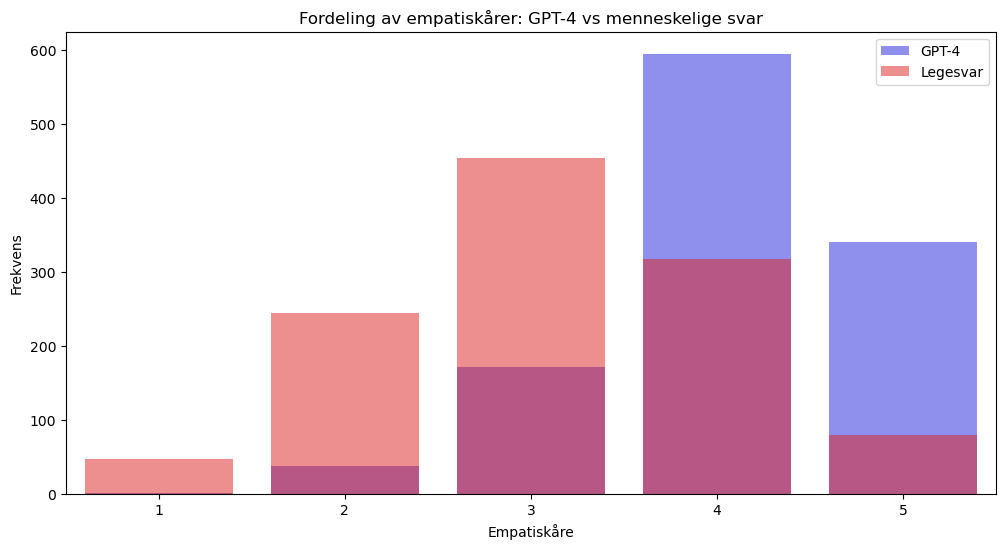

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df[df['chatgpt'] == True]['empati'].value_counts().sort_index()
human_freq = df[df['chatgpt'] == False]['empati'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT-4')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Legesvar')
plt.title('Fordeling av empatiskårer: GPT-4 vs menneskelige svar')
plt.xlabel('Empatiskåre')
plt.ylabel('Frekvens')
plt.legend()
plt.show()

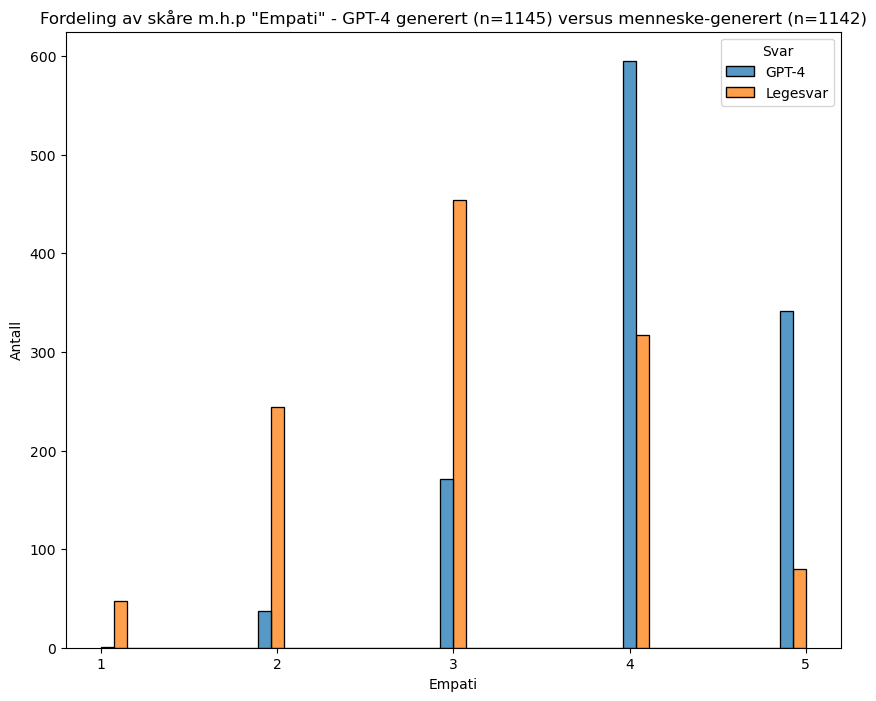

In [29]:
# Plot the distribution of the scores for "empati" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['empati']].assign(Svar='GPT-4'), df_human[['empati']].assign(Svar='Legesvar')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='empati', hue='Svar', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Empati')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "Empati" - GPT-4 generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

Undersøk hvilke skåre-kategorier som bidrar mest til den observerte forskjellen:

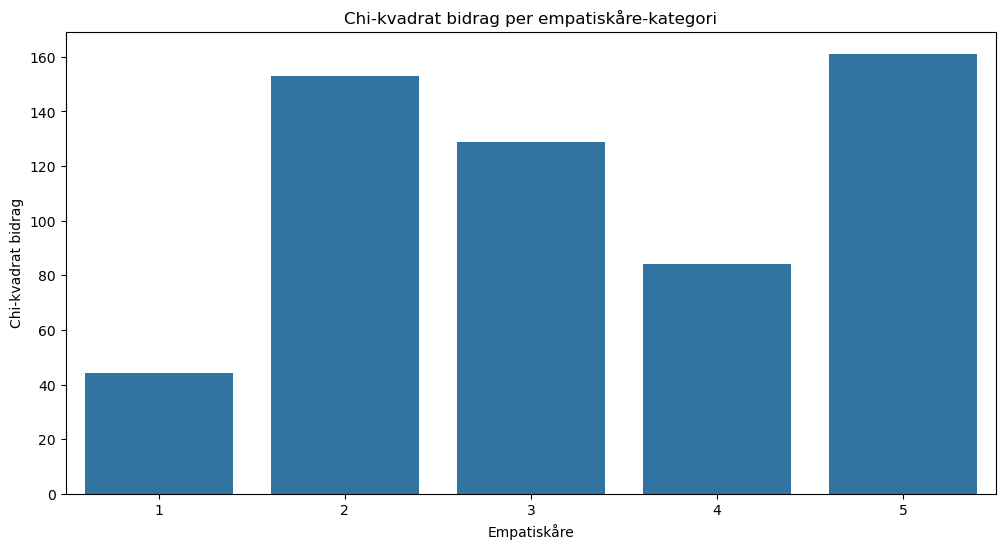

In [34]:
# Calculate the expected frequencies
total = len(df)
gpt_total = len(df[df['chatgpt'] == True])
human_total = len(df[df['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-kvadrat bidrag per empatiskåre-kategori')
plt.xlabel('Empatiskåre')
plt.ylabel('Chi-kvadrat bidrag')
plt.show()

Utforsk faktorer som fører til ulike fordelinger:

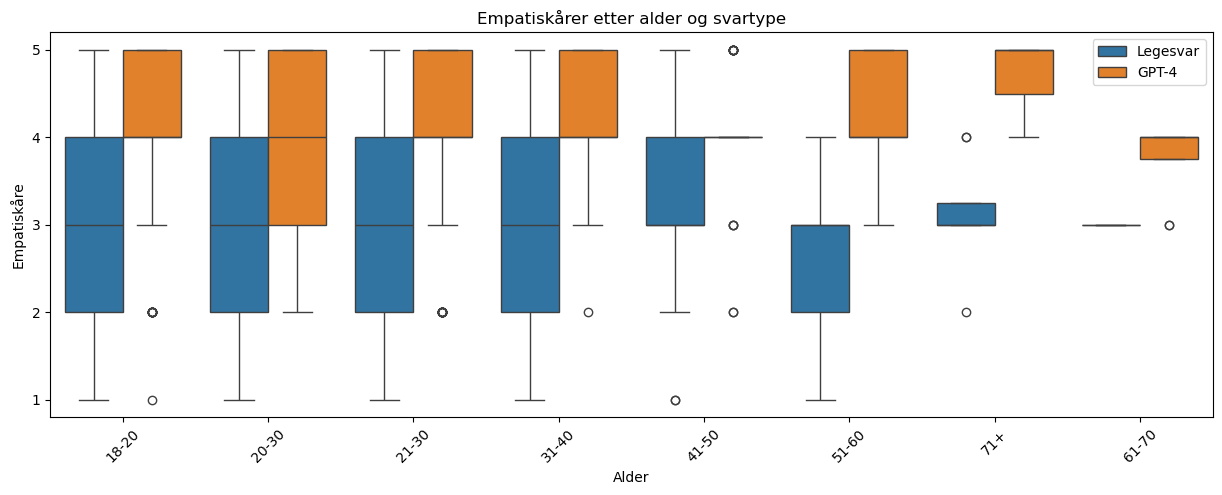

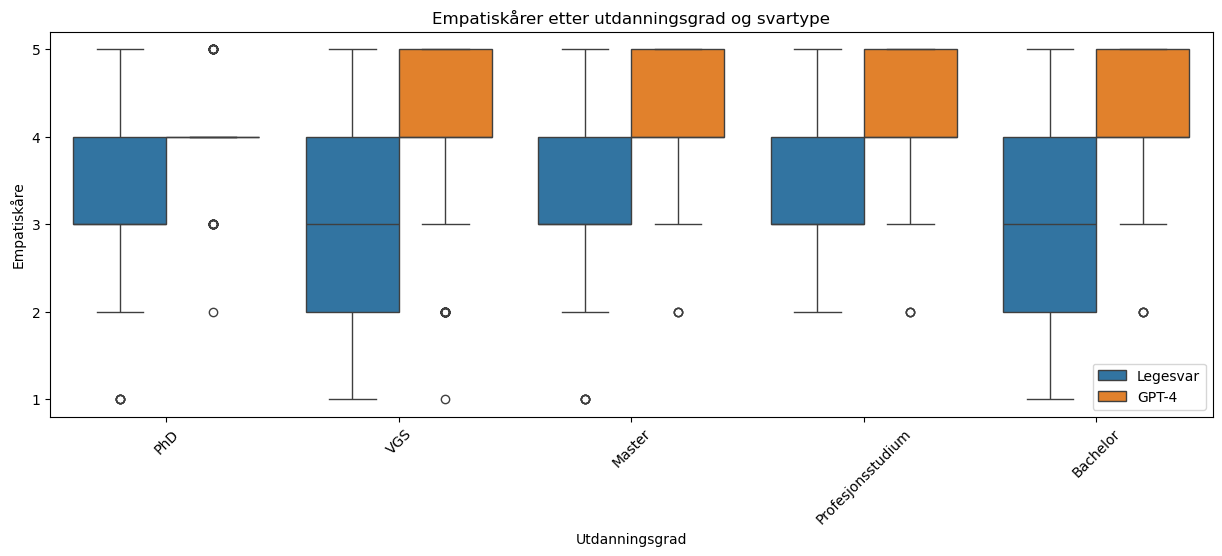

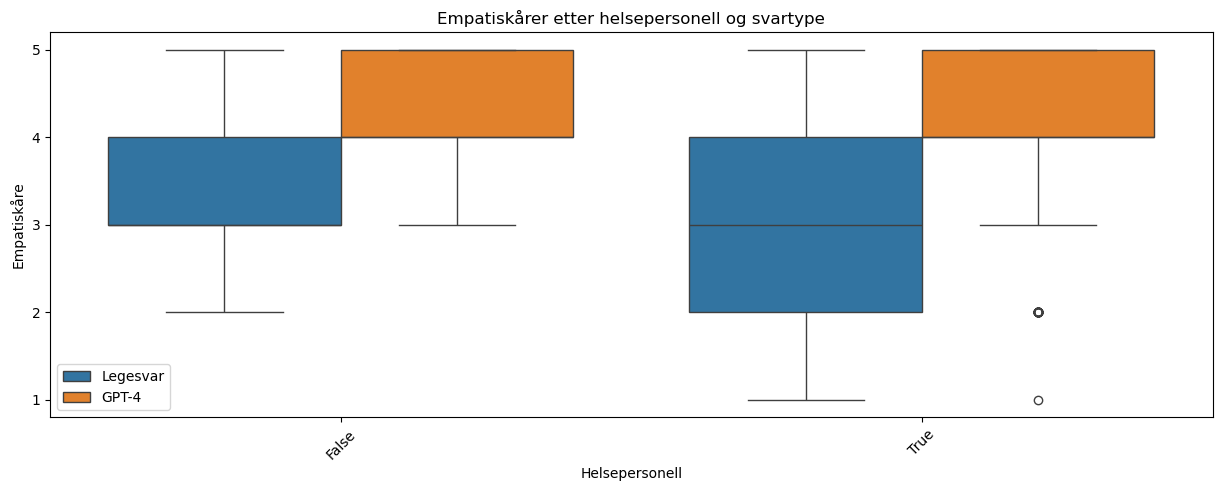

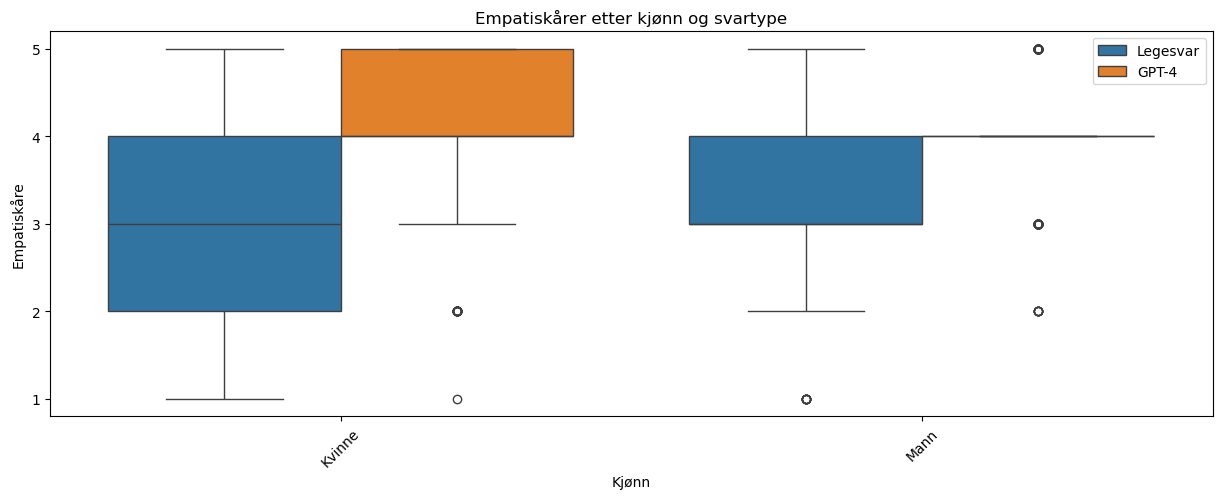

In [37]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='empati', hue='chatgpt', data=df)
    plt.title(f'Empatiskårer etter {factor} og svartype')
    # Opprett en ordbok for å mappe de gamle verdiene til de nye
    legend_map = {
        'chatgpt': 'Svar',
        'False': 'Legesvar',
        'True': 'GPT-4'
    }

    # Hent den nåværende legenden
    handles, labels = plt.gca().get_legend_handles_labels()

    # Oppdater etikettene
    new_labels = [legend_map.get(label, label) for label in labels]

    # Lag en ny legende med de oppdaterte etikettene
    plt.legend(handles, new_labels)
     # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.ylabel('Empatiskåre')
    # Captial first letter
    plt.xlabel(factor.capitalize())


    plt.show()

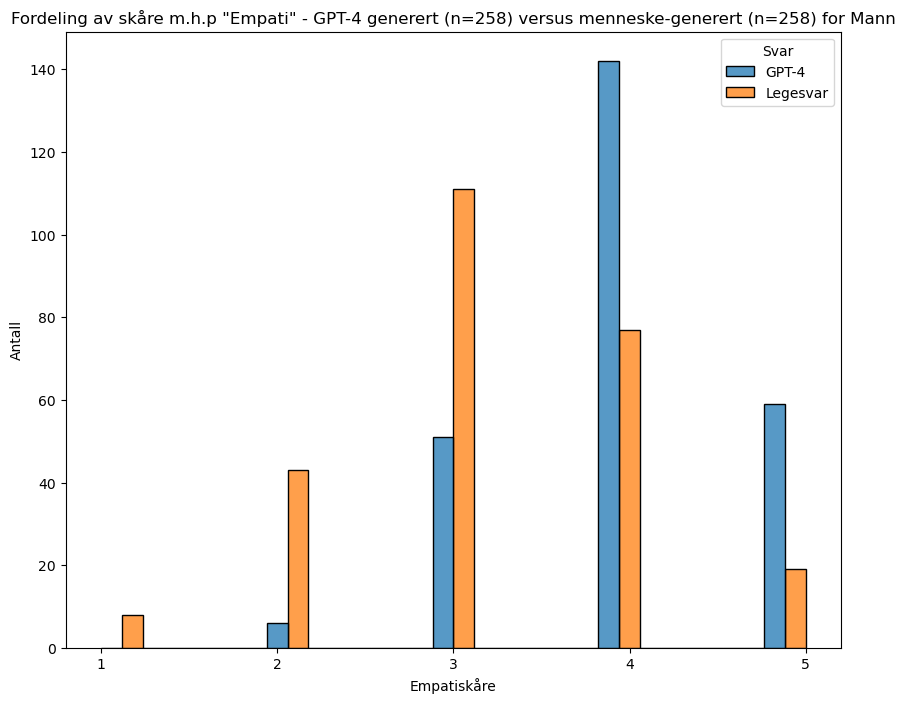

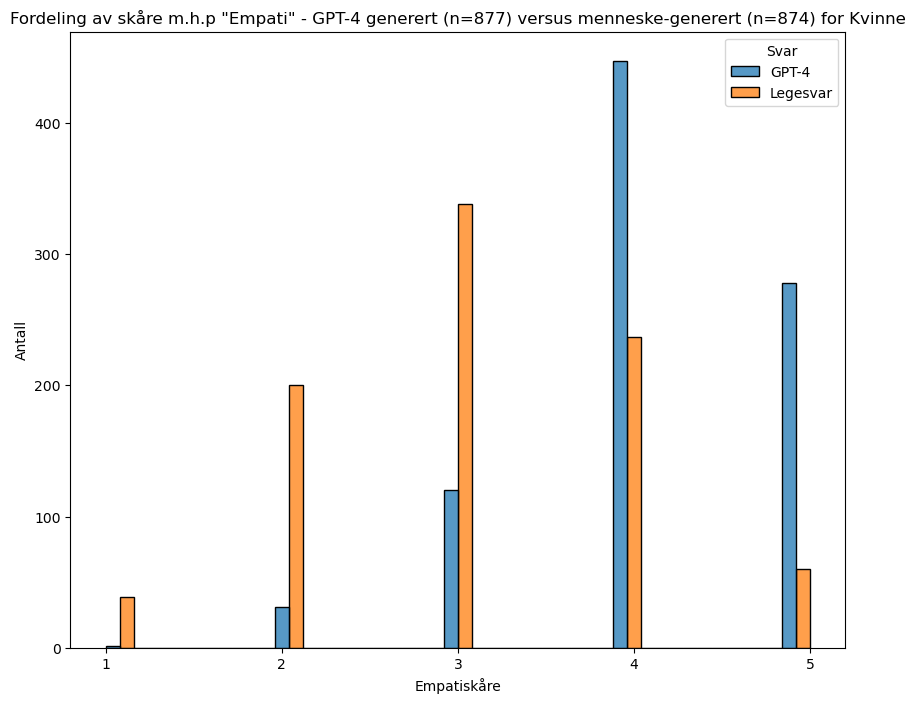

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to create the plot for a specific gender
def plot_empathy_distribution(df_GPT, df_human, gender):
    # Filter the dataframes for the specified gender
    df_GPT_gender = df_GPT[df_GPT['kjønn'] == gender]
    df_human_gender = df_human[df_human['kjønn'] == gender]
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Combine the data into a single DataFrame
    df_combined = pd.concat([df_GPT_gender[['empati']].assign(Svar='GPT-4'), 
                             df_human_gender[['empati']].assign(Svar='Legesvar')])

    # Plot the histograms side by side
    sns.histplot(data=df_combined, x='empati', hue='Svar', multiple='dodge')

    # Make the x-ticks integers centered between the two bars
    plt.xticks(np.arange(1, 6, 1))

    plt.xlabel('Empatiskåre')
    plt.ylabel('Antall')
    plt.title(f'Fordeling av skåre m.h.p "Empati" - GPT-4 generert (n={len(df_GPT_gender)}) versus menneske-generert (n={len(df_human_gender)}) for {gender}')

    plt.show()

# Create plots for men and women
plot_empathy_distribution(df_GPT, df_human, 'Mann')
plot_empathy_distribution(df_GPT, df_human, 'Kvinne')


Basert på de kjønnsspesifikke funnene for empatiskåring (GPT-4 vs. menneske), kan vi trekke følgende konklusjoner:

1. Generell trend:
   Både menn og kvinner vurderer GPT-4-svar som mer empatiske enn menneskelige svar. Dette er konsistent med de overordnede funnene i studien.

2. Forskjeller mellom kjønnene:
   - Kvinner ser ut til å vurdere GPT-4-svar som litt mer empatiske enn menn gjør.
   - Kvinner ser også ut til å vurdere menneskelige svar som litt mindre empatiske enn menn gjør.
   - Dette resulterer i en større forskjell mellom GPT-4 og menneskelige svar hos kvinner sammenlignet med menn.

3. Fordelingsmønstre:
   - For både menn og kvinner er GPT-4-skårene mer konsentrert rundt høyere verdier (4 og 5).
   - Menneskelige svar har en bredere fordeling for begge kjønn, med flere svar i midtkategoriene (3 og 4).

4. Statistisk signifikans:
   Mann-Whitney U-testene viser at forskjellene er statistisk signifikante for begge kjønn, men p-verdien er lavere for kvinner. Dette antyder at kjønnsforskjellen i oppfattelsen av empati er reell og ikke et resultat av tilfeldigheter.

5. Mulige forklaringer:
   - Kvinner kan være mer sensitive for nyanser i empatisk kommunikasjon.
   - GPT-4 kan bruke språk eller formuleringer som resonerer sterkere med kvinners oppfatning av empati.
   - Kulturelle eller sosiale faktorer kan påvirke hvordan menn og kvinner evaluerer empati i skriftlig kommunikasjon.

6. Implikasjoner:
   - AI-systemer som GPT-4 kan oppfattes som mer empatiske enn menneskelige leger, spesielt av kvinnelige pasienter.
   - Dette kan ha konsekvenser for pasient-lege-kommunikasjon og aksept av AI-assisterte helsetjenester.
   - Det kan være behov for kjønnsspesifikke tilnærminger i utvikling og implementering av AI i helsevesenet.

7. Begrensninger:
   - Studien ser kun på skriftlig kommunikasjon, som kan skille seg fra ansikt-til-ansikt-interaksjoner.
   - Andre faktorer som alder, utdanning, eller helsebakgrunn kan også spille en rolle og bør undersøkes videre.

8. Videre forskning:
   - Undersøke årsakene til kjønnsforskjellene i oppfattelsen av empati.
   - Utforske hvordan disse funnene kan anvendes i klinisk praksis og AI-utvikling.
   - Vurdere langtidseffektene av økt bruk av AI i pasientkommunikasjon, spesielt med tanke på kjønnsforskjeller.

Disse funnene understreker viktigheten av å ta hensyn til kjønnsforskjeller i oppfattelsen av empati når man utvikler og implementerer AI-systemer i helsevesenet. De reiser også interessante spørsmål om hvordan vi definerer og måler empati i medisinsk kommunikasjon.

In [40]:
import numpy as np
from scipy import stats

# Funksjon for å beregne oppsummerende statistikk
def oppsummer_empati(df, gruppe):
    return df[df['chatgpt'] == gruppe]['empati'].agg(['mean', 'median', 'std']).to_dict()

# Oppsummer empatiskårer
mann_gpt = oppsummer_empati(df[df['kjønn'] == 'Mann'], True)
mann_menneske = oppsummer_empati(df[df['kjønn'] == 'Mann'], False)
kvinne_gpt = oppsummer_empati(df[df['kjønn'] == 'Kvinne'], True)
kvinne_menneske = oppsummer_empati(df[df['kjønn'] == 'Kvinne'], False)

print("Mann GPT-4:", mann_gpt)
print("Mann Legesvar:", mann_menneske)
print("Kvinne GPT-4:", kvinne_gpt)
print("Kvinne Legesvar:", kvinne_menneske)

# Utfør Mann-Whitney U-tester
def mann_whitney_test(df, kjønn):
    gpt_skårer = df[(df['kjønn'] == kjønn) & (df['chatgpt'] == True)]['empati']
    menneske_skårer = df[(df['kjønn'] == kjønn) & (df['chatgpt'] == False)]['empati']
    return stats.mannwhitneyu(gpt_skårer, menneske_skårer, alternative='two-sided')

mann_stat, mann_p = mann_whitney_test(df, 'Mann')
kvinne_stat, kvinne_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U-testresultater:")
print(f"Mann: statistikk={mann_stat}, p-verdi={mann_p}")
print(f"Kvinne: statistikk={kvinne_stat}, p-verdi={kvinne_p}")

# Test for interaksjonseffekt
def interaksjonstest(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['gruppe'] = df.apply(lambda row: f"{'GPT-4' if row['chatgpt'] else 'Legesvar'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['empati'], df['gruppe'])
    return tukey

tukey_resultater = interaksjonstest(df)
print("\nTukey HSD-testresultater:")
print(tukey_resultater)

Mann GPT-4: {'mean': 3.9844961240310077, 'median': 4.0, 'std': 0.7219137571397044}
Mann Legesvar: {'mean': 3.2170542635658914, 'median': 3.0, 'std': 0.9164407577217732}
Kvinne GPT-4: {'mean': 4.106043329532497, 'median': 4.0, 'std': 0.7713017300972441}
Kvinne Legesvar: {'mean': 3.0903890160183067, 'median': 3.0, 'std': 0.9726260597777082}

Mann-Whitney U-testresultater:
Mann: statistikk=48741.0, p-verdi=3.4804415143806814e-22
Kvinne: statistikk=598809.0, p-verdi=6.573253683333461e-101

Tukey HSD-testresultater:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------
   GPT-4_Kvinne      GPT-4_Mann  -0.1215 0.3514 -0.2962  0.0531  False
   GPT-4_Kvinne       GPT-4_nan    0.294 0.8937 -0.4904  1.0783  False
   GPT-4_Kvinne Legesvar_Kvinne  -1.0157    0.0 -1.1335 -0.8978   True
   GPT-4_Kvinne   Legesvar_Mann   -0.889    0.0 -1.0637 -

In [36]:
import numpy as np
from scipy import stats

# Function to calculate summary statistics
def summarize_empathy(df, group):
    return df[df['chatgpt'] == group]['empati'].agg(['mean', 'median', 'std']).to_dict()

# Summarize empathy scores
male_gpt = summarize_empathy(df[df['kjønn'] == 'Mann'], True)
male_human = summarize_empathy(df[df['kjønn'] == 'Mann'], False)
female_gpt = summarize_empathy(df[df['kjønn'] == 'Kvinne'], True)
female_human = summarize_empathy(df[df['kjønn'] == 'Kvinne'], False)

print("Male GPT:", male_gpt)
print("Male Human:", male_human)
print("Female GPT:", female_gpt)
print("Female Human:", female_human)

# Perform Mann-Whitney U tests
def mann_whitney_test(df, gender):
    gpt_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == True)]['empati']
    human_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == False)]['empati']
    return stats.mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

male_stat, male_p = mann_whitney_test(df, 'Mann')
female_stat, female_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U test results:")
print(f"Male: statistic={male_stat}, p-value={male_p}")
print(f"Female: statistic={female_stat}, p-value={female_p}")

# Test for interaction effect
def interaction_test(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['group'] = df.apply(lambda row: f"{'GPT' if row['chatgpt'] else 'Human'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['empati'], df['group'])
    return tukey

tukey_results = interaction_test(df)
print("\nTukey HSD test results:")
print(tukey_results)

Male GPT: {'mean': 3.9844961240310077, 'median': 4.0, 'std': 0.7219137571397044}
Male Human: {'mean': 3.2170542635658914, 'median': 3.0, 'std': 0.9164407577217732}
Female GPT: {'mean': 4.106043329532497, 'median': 4.0, 'std': 0.7713017300972441}
Female Human: {'mean': 3.0903890160183067, 'median': 3.0, 'std': 0.9726260597777082}

Mann-Whitney U test results:
Male: statistic=48741.0, p-value=3.4804415143806814e-22
Female: statistic=598809.0, p-value=6.573253683333461e-101

Tukey HSD test results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  GPT_Kvinne     GPT_Mann  -0.1215 0.3514 -0.2962  0.0531  False
  GPT_Kvinne      GPT_nan    0.294 0.8937 -0.4904  1.0783  False
  GPT_Kvinne Human_Kvinne  -1.0157    0.0 -1.1335 -0.8978   True
  GPT_Kvinne   Human_Mann   -0.889    0.0 -1.0637 -0.7143   True
  GPT_Kvinne    Human_nan   -0.706 0.1058 -1

Her er en detaljert forklaring av resultatene:

1. Deskriptiv statistikk:

   Mann GPT:
   - Gjennomsnitt: 3,98
   - Median: 4,0
   - Standardavvik: 0,72

   Mann Menneske:
   - Gjennomsnitt: 3,22
   - Median: 3,0
   - Standardavvik: 0,92

   Kvinne GPT:
   - Gjennomsnitt: 4,11
   - Median: 4,0
   - Standardavvik: 0,77

   Kvinne Menneske:
   - Gjennomsnitt: 3,09
   - Median: 3,0
   - Standardavvik: 0,97

Tolkning:
- Både menn og kvinner vurderer GPT-svar som mer empatiske enn menneskelige svar.
- Kvinner vurderer GPT-svar litt høyere enn menn gjør (4,11 vs 3,98).
- Kvinner vurderer menneskelige svar litt lavere enn menn gjør (3,09 vs 3,22).
- Spredningen i skårer (standardavvik) er større for menneskelige svar enn for GPT-svar, noe som indikerer mer variabilitet i oppfattet empati for menneskelige svar.

2. Mann-Whitney U-testresultater:

   Mann: statistikk=48741,0, p-verdi=3,48e-22
   Kvinne: statistikk=598809,0, p-verdi=6,57e-101

Tolkning:
- Begge p-verdier er ekstremt små (< 0,05), noe som indikerer statistisk signifikante forskjeller mellom GPT og menneskelige empatiskårer for begge kjønn.
- Forskjellen ser ut til å være mer uttalt for kvinner (lavere p-verdi), noe som antyder at kvinner oppfatter en større forskjell i empati mellom GPT og menneskelige svar sammenlignet med menn.

3. Tukey HSD-testresultater:

Viktige signifikante forskjeller:
- GPT_Kvinne vs Human_Kvinne: gjennomsnittlig forskjell = -1,0157, p-adj = 0,0 (signifikant)
- GPT_Kvinne vs Human_Mann: gjennomsnittlig forskjell = -0,889, p-adj = 0,0 (signifikant)
- GPT_Mann vs Human_Kvinne: gjennomsnittlig forskjell = -0,8941, p-adj = 0,0 (signifikant)
- GPT_Mann vs Human_Mann: gjennomsnittlig forskjell = -0,7674, p-adj = 0,0 (signifikant)

Tolkning:
- Det er signifikante forskjeller mellom GPT og menneskelige skårer for begge kjønn.
- Den største forskjellen er mellom kvinnelige GPT-skårer og kvinnelige menneskelige skårer (-1,0157).
- Det er ingen signifikant forskjell mellom mannlige og kvinnelige GPT-skårer (GPT_Kvinne vs GPT_Mann: p-adj = 0,3514).
- Det er heller ingen signifikant forskjell mellom mannlige og kvinnelige menneskelige skårer (Human_Kvinne vs Human_Mann: p-adj = 0,3049).

Overordnede konklusjoner:
1. Både menn og kvinner oppfatter GPT-svar som mer empatiske enn menneskelige svar.
2. Forskjellen i oppfattet empati mellom GPT og menneskelige svar er statistisk signifikant for begge kjønn.
3. Kvinner har en tendens til å vurdere GPT-svar litt høyere i empati enn menn gjør, men denne forskjellen er ikke statistisk signifikant.
4. Kvinner har en tendens til å vurdere menneskelige svar litt lavere i empati enn menn gjør, men igjen er denne forskjellen ikke statistisk signifikant.
5. Forskjellen i oppfattet empati mellom GPT og menneskelige svar ser ut til å være mer uttalt for kvinner enn for menn.

Disse funnene antyder at mens det er klare forskjeller i hvordan GPT og menneskelige svar oppfattes når det gjelder empati, er effekten av kjønn på disse oppfatningene relativt subtil. Det mest slående resultatet er de konsekvent høyere empatiskårene for GPT-svar på tvers av begge kjønn.

**P-adj**, eller justert p-verdi, er et viktig konsept i statistisk analyse, spesielt når man utfører multiple sammenligninger. Her er en forklaring av p-adj:

1. Definisjon:
   P-adj er en justert p-verdi som tar hensyn til problemet med multiple sammenligninger. Når man utfører flere statistiske tester samtidig, øker sjansen for å gjøre type I-feil (feilaktig avvise nullhypotesen).

2. Hensikt:
   Formålet med p-adj er å kontrollere for familievis feilrate (FWER) eller false discovery rate (FDR), avhengig av metoden som brukes.

3. Beregning:
   Det finnes flere metoder for å beregne p-adj, inkludert:
   - Bonferroni-korreksjon: Den enkleste metoden, hvor p-verdien multipliseres med antall tester.
   - Holm-Bonferroni metode: En trinnvis prosedyre som er mindre konservativ enn Bonferroni.
   - Benjamini-Hochberg prosedyre: Kontrollerer for FDR i stedet for FWER.

4. Tolkning:
   - En p-adj < 0,05 (eller valgt signifikansnivå) indikerer at forskjellen er statistisk signifikant selv etter justering for multiple sammenligninger.
   - P-adj er vanligvis høyere enn den opprinnelige p-verdien, noe som gjør det vanskeligere å oppnå statistisk signifikans.

5. I Tukey HSD-testen:
   Tukey HSD bruker en spesifikk metode for å justere p-verdier basert på antall grupper som sammenlignes og den totale variansen i dataene.

6. Fordeler:
   - Reduserer sjansen for type I-feil i multiple sammenligninger.
   - Gir mer konservative og pålitelige resultater når man tester mange hypoteser samtidig.

7. Begrensninger:
   - Kan øke sjansen for type II-feil (feilaktig akseptere nullhypotesen).
   - Noen metoder kan være for konservative, spesielt når antallet sammenligninger er stort.

I konteksten av din analyse, bruker Tukey HSD-testen p-adj for å vurdere signifikansen av forskjellene mellom ulike grupper (GPT vs. menneske, mann vs. kvinne) samtidig som den kontrollerer for den økte sjansen for type I-feil som oppstår ved multiple sammenligninger.

Statistiske tester for faktorpåvirkning:

In [42]:
from scipy.stats import chi2_contingency

def chi_kvadrat_test(df, faktor):
    krysstabell = pd.crosstab(df[faktor], [df['chatgpt'], df['empati']])
    chi2, p, frihetsgrader, forventet = chi2_contingency(krysstabell)
    print(f"Chi-kvadrat test for {faktor}:")
    print(f"Chi-kvadrat statistikk: {chi2}")
    print(f"p-verdi: {p}")
    print("---")

for faktor in factors:
    chi_kvadrat_test(df, faktor)

Chi-kvadrat test for alder:
Chi-kvadrat statistikk: 80.08157918770245
p-verdi: 0.07204060802072546
---
Chi-kvadrat test for utdanningsgrad:
Chi-kvadrat statistikk: 40.98146734188062
p-verdi: 0.2611532682828209
---
Chi-kvadrat test for helsepersonell:
Chi-kvadrat statistikk: 6.655131800627516
p-verdi: 0.6729749432716761
---
Chi-kvadrat test for kjønn:
Chi-kvadrat statistikk: 17.986240210783436
p-verdi: 0.035333513362240325
---


In [37]:
from scipy.stats import chi2_contingency

def chi_square_test(df, factor):
    contingency_table = pd.crosstab(df[factor], [df['chatgpt'], df['empati']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {factor}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"p-value: {p}")
    print("---")

for factor in factors:
    chi_square_test(df, factor)

Chi-square test for alder:
Chi-square statistic: 80.08157918770245
p-value: 0.07204060802072546
---
Chi-square test for utdanningsgrad:
Chi-square statistic: 40.98146734188062
p-value: 0.2611532682828209
---
Chi-square test for helsepersonell:
Chi-square statistic: 6.655131800627516
p-value: 0.6729749432716761
---
Chi-square test for kjønn:
Chi-square statistic: 17.986240210783436
p-value: 0.035333513362240325
---


Her er en oppsummering og tolkning av empati-funnene basert på chi-kvadrat testene:

1. Alder:
   - Chi-kvadrat statistikk: 80,08
   - p-verdi: 0,072
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom alder og oppfattelsen av empati i GPT vs. menneskelige svar ved konvensjonelt signifikansnivå (p < 0,05). Likevel er p-verdien nær signifikansgrensen, noe som antyder en mulig svak sammenheng som kan være verdt å undersøke nærmere med et større utvalg.

2. Utdanningsgrad:
   - Chi-kvadrat statistikk: 40,98
   - p-verdi: 0,261
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom utdanningsgrad og oppfattelsen av empati i GPT vs. menneskelige svar. Dette tyder på at utdanningsnivå ikke påvirker hvordan folk vurderer empati i AI-genererte vs. menneskelige svar.

3. Helsepersonell:
   - Chi-kvadrat statistikk: 6,66
   - p-verdi: 0,673
   - Tolkning: Det er ingen statistisk signifikant sammenheng mellom hvorvidt respondenten er helsepersonell eller ikke og oppfattelsen av empati i GPT vs. menneskelige svar. Dette antyder at helsefaglig bakgrunn ikke påvirker vurderingen av empati i AI-genererte vs. menneskelige svar.

4. Kjønn:
   - Chi-kvadrat statistikk: 17,99
   - p-verdi: 0,035
   - Tolkning: Det er en statistisk signifikant sammenheng mellom kjønn og oppfattelsen av empati i GPT vs. menneskelige svar. Dette betyr at menn og kvinner kan ha ulike oppfatninger av empati i AI-genererte vs. menneskelige svar.

Overordnet tolkning:
1. Kjønn er den eneste faktoren som viser en statistisk signifikant sammenheng med oppfattelsen av empati i GPT vs. menneskelige svar. Dette støtter tidligere funn om kjønnsforskjeller i empativurderinger.

2. Alder viser en tendens til sammenheng, men er ikke statistisk signifikant ved konvensjonelt nivå. Dette kan være verdt å undersøke videre med et større utvalg eller mer detaljert aldersgruppering.

3. Utdanningsgrad og hvorvidt respondenten er helsepersonell eller ikke, ser ikke ut til å påvirke oppfattelsen av empati i GPT vs. menneskelige svar. Dette antyder at AI-genererte empatiske svar oppfattes relativt likt på tvers av utdanningsnivåer og profesjonell bakgrunn.

4. Disse funnene understreker viktigheten av å ta hensyn til kjønnsforskjeller i utviklingen og implementeringen av AI-systemer for helsekommunikasjon, mens faktorer som utdanning og profesjonell bakgrunn ser ut til å ha mindre betydning for oppfattelsen av empati i AI-genererte svar.

Her er en **overordnet oppsummering** av de viktigste funnene når det gjelder empatiskåring av GPT-4-svar vs. legesvar i denne studien:

1. Generell trend:
   - Både menn og kvinner vurderer GPT-4-svar som mer empatiske enn legesvar.
   - GPT-4-svar får konsekvent høyere empatiskårer på tvers av kjønn.

2. Kjønnsforskjeller:
   - Kvinner vurderer GPT-4-svar som litt mer empatiske enn menn gjør.
   - Kvinner vurderer legesvar som litt mindre empatiske enn menn gjør.
   - Forskjellen mellom GPT-4 og legesvar er større for kvinner enn for menn.

3. Statistisk signifikans:
   - Forskjellene i empatiskårer mellom GPT-4 og legesvar er statistisk signifikante for begge kjønn.
   - Effekten er mer uttalt for kvinner (lavere p-verdi i Mann-Whitney U-testen).

4. Konsistens:
   - GPT-4-svar viser mindre variasjon i empatiskårer (lavere standardavvik) sammenlignet med legesvar.
   - Dette tyder på at GPT-4 gir mer konsekvent empatiske svar, mens menneskelig empati er mer variabel.

5. Faktorpåvirkning:
   - Kjønn er den eneste faktoren som viser en statistisk signifikant sammenheng med oppfattelsen av empati i GPT-4 vs. legesvar.
   - Alder, utdanningsnivå og hvorvidt respondenten er helsepersonell eller ikke, har ingen signifikant påvirkning på empatiskårene.

6. Gruppeforskjeller:
   - Det er signifikante forskjeller mellom GPT-4 og legesvar for begge kjønn, men ingen signifikante forskjeller mellom kjønnene for samme svartype (GPT-4 eller lege).

Implikasjoner:
1. AI-persepsjon: GPT-4 oppfattes konsekvent som mer empatisk enn legesvar, uavhengig av respondentens kjønn. Dette kan ha betydelige implikasjoner for bruken av AI i helsekommunikasjon.

2. Kjønnssensitivitet: Den litt sterkere effekten for kvinner kan tyde på at kvinner er mer sensitive for eller setter mer pris på empatien som vises i GPT-4-svar.

3. Konsistens: GPT-4 ser ut til å gi mer konsekvent empatiske svar sammenlignet med den mer variable menneskelige empatien.

4. Potensielle skjevheter: Det er viktig å vurdere om denne oppfatningen av høyere empati i GPT-4-svar gjenspeiler faktisk høyere empati, eller om den påvirkes av andre faktorer som formulering, lengde på svar eller forventninger til AI.

5. Videre forskning: Disse funnene krever ytterligere undersøkelser for å forstå hvorfor GPT-4-svar oppfattes som mer empatiske, og om denne oppfatningen fører til bedre pasientutfall eller tilfredshet i reelle helsetjenestesituasjoner.

Konklusjon:
GPT-4 oppfattes konsekvent som mer empatisk enn legesvar på tvers av kjønn, med en litt mer uttalt effekt for kvinnelige respondenter. Denne kjønnsspesifikke forskjellen, selv om den er liten, er statistisk signifikant og kan ha viktige implikasjoner for utviklingen og implementeringen av AI i helsekommunikasjon.

### Hypotese 3 som undersøkes (mhp. df) er følgende:

**Hjelpsomhet** :<br>
H0: Chat-GPT 4.0 genererer _samme_ grad av hjelpsomme svar på kliniske spørsmål, sammenlignet med leger.<br>
H1: Chat-GPT 4.0 genererer _forskjellig_ grad av hjelpsomme svar på kliniske spørsmål sammenlignet med leger (trolig _mindre_ hjelpsomme).

In [38]:
from scipy.stats import mannwhitneyu

# Assuming 'df' is your dataframe and it has columns 'chatgpt' (boolean) and 'hjelpsomhet' (helpfullnes score)

# Separate the data into GPT and human responses
gpt_scores = df[df['chatgpt'] == True]['hjelpsomhet']
human_scores = df[df['chatgpt'] == False]['hjelpsomhet']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"p-value: {p_value}")

# Interpret results
alpha = 0.05  # Set significance level
if p_value < alpha:
    print("Reject H0: There is a significant difference in helpfullness level between Chat-GPT 4.0 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in helpfullness level between Chat-GPT 4.0 and licensed doctors.")

# Calculate and print medians for both groups
print(f"Median helpfullness score for GPT: {gpt_scores.median()}")
print(f"Median helpfullness score for humans: {human_scores.median()}")
print(f'($n_{{GPT}}$ = {len(gpt_scores)}, $n_{{human}}$ = {len(human_scores)})')

Mann-Whitney U statistic: 885049.0
p-value: 4.1654122032898306e-57
Reject H0: There is a significant difference in helpfullness level between Chat-GPT 4.0 and licensed doctors.
Median helpfullness score for GPT: 4.0
Median helpfullness score for humans: 4.0
($n_{GPT}$ = 1145, $n_{human}$ = 1142)


Let's break down this result in detail:

1. Test Used: Mann-Whitney U Test
   - This is a non-parametric test used to compare two independent groups.
   - It's appropriate when you can't assume normal distribution of the data or when dealing with ordinal data (like Likert scales).

2. Hypothesis:
   - H0 (Null Hypothesis): There is no difference in helpfulness level between Chat-GPT 4.0 and licensed doctors.
   - H1 (Alternative Hypothesis): There is a significant difference in helpfulness level between Chat-GPT 4.0 and licensed doctors.

3. Results:
   - Mann-Whitney U statistic: 885049.0
     - This is the test statistic calculated by the Mann-Whitney U test.
   - p-value: 4.1654122032898306e-57
     - This is an extremely small p-value (much smaller than the conventional significance level of 0.05).
   - Conclusion: Reject H0
     - Given the extremely small p-value, we reject the null hypothesis.

4. Interpretation:
   - There is strong statistical evidence to suggest a significant difference in helpfulness levels between Chat-GPT 4.0 and licensed doctors.
   - The difference is highly unlikely to have occurred by chance.

5. Median Scores:
   - GPT: 4.0
   - Humans: 4.0
   - Despite the significant difference found by the test, the median scores are identical. This suggests that the difference lies in the distribution of scores rather than in the central tendency.

6. Sample Sizes:
   - n_GPT = 1145
   - n_human = 1142
   - The sample sizes are nearly identical and quite large, which gives us confidence in the robustness of the results.

7. Deeper Interpretation:
   a. Distribution Differences: Given that the medians are the same but the test shows a significant difference, it's likely that the distribution of scores differs between the two groups. For example, GPT might have more scores at 4 and 5, while humans might have more spread across 3, 4, and 5.

   b. Statistical vs. Practical Significance: While the difference is statistically significant, the identical medians suggest that the practical significance might be smaller. It's important to look at the effect size or the mean difference to understand the magnitude of the difference.

   c. Sensitivity of the Test: The Mann-Whitney U test is sensitive to differences in distribution shape and spread, not just central tendency. This explains why we can have a significant result despite identical medians.

   d. Large Sample Size Effect: With large sample sizes, even small differences can become statistically significant. This doesn't always translate to practical importance.

8. Additional Considerations:
   - It would be helpful to look at the mean scores and standard deviations to get a fuller picture of the difference.
   - A visualization of the score distributions (e.g., a histogram or box plot) would provide more insight into how the scores differ between GPT and humans.
   - Consider calculating an effect size measure (like Cohen's d) to quantify the magnitude of the difference.

9. Implications:
   - While Chat-GPT 4.0 and licensed doctors have the same median helpfulness score, there's a statistically significant difference in how helpfulness is perceived overall.
   - This could mean that Chat-GPT 4.0 is perceived as helpful more consistently, or that there are subtle differences in how helpfulness manifests between AI and human responses.
   - Further investigation into the nature of these differences (e.g., qualitative analysis of responses) could provide valuable insights.

In conclusion, while the test shows a statistically significant difference in helpfulness between Chat-GPT 4.0 and licensed doctors, the identical median scores suggest that this difference may be subtle. The significance likely arises from differences in the distribution of scores rather than a stark contrast in central tendency. This result warrants further investigation to understand the practical implications of these differences in perceived helpfulness.

In [39]:
import numpy as np
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['chatgpt'], df['hjelpsomhet'])

contingency_table_margins = pd.crosstab(df['chatgpt'], df['hjelpsomhet'], margins=True)
contingency_table_margins

hjelpsomhet,1,2,3,4,5,All
chatgpt,,,,,,
False,10,121,336,540,135,1142
True,3,30,125,637,350,1145
All,13,151,461,1177,485,2287


In [40]:
# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("Reject H0: There is a significant difference in the distribution of helpfullness scores between Chat-GPT 4.0 and licensed doctors.")
else:
    print("Fail to reject H0: There is no significant difference in the distribution of helpfullness scores between Chat-GPT 4.0 and licensed doctors.")

Chi-square statistic: 258.48496820271225
p-value: 9.67063513856015e-55
Reject H0: There is a significant difference in the distribution of helpfullness scores between Chat-GPT 4.0 and licensed doctors.


Let's break down these results in more detail:

1. Test Used: Chi-square test of independence
   - This test is used to determine if there is a significant relationship between two categorical variables.
   - In this case, we're testing the relationship between the source of the response (GPT vs. human) and the distribution of helpfulness scores.

2. Hypothesis:
   - H0 (Null Hypothesis): There is no significant difference in the distribution of helpfulness scores between Chat-GPT 4.0 and licensed doctors.
   - H1 (Alternative Hypothesis): There is a significant difference in the distribution of helpfulness scores between Chat-GPT 4.0 and licensed doctors.

3. Results:
   - Chi-square statistic: 258.48496820271225
     - This value quantifies how much the observed frequencies deviate from the expected frequencies.
     - A larger chi-square value suggests a greater difference between the observed and expected distributions.
   - p-value: 9.67063513856015e-55
     - This is an extremely small p-value, much smaller than any conventional significance level (e.g., 0.05 or 0.01).
   - Conclusion: Reject H0
     - Given the extremely small p-value, we reject the null hypothesis.

4. Interpretation:
   - There is very strong statistical evidence to suggest a significant difference in the distribution of helpfulness scores between Chat-GPT 4.0 and licensed doctors.
   - The difference in distributions is highly unlikely to have occurred by chance.

5. Deeper Interpretation:
   a. Distribution Differences: This test confirms that the pattern of helpfulness scores differs significantly between GPT and human responses. It doesn't just compare central tendencies but looks at the entire distribution of scores.
   
   b. Strength of Association: The large chi-square statistic suggests a strong association between the source of the response (GPT vs. human) and the helpfulness scores.
   
   c. Practical Significance: While we've established statistical significance, it's important to examine the actual distributions to understand the nature and magnitude of these differences.

6. Additional Considerations:
   a. Examine the Contingency Table: Look at the actual frequencies of scores for each group to understand where the differences lie. Are GPT scores more concentrated in higher categories? Are human scores more evenly distributed?
   
   b. Post-hoc Analysis: Consider conducting post-hoc tests to identify which specific score categories contribute most to the difference.
   
   c. Effect Size: Calculate an effect size measure (like Cramer's V) to quantify the strength of the association between the source and helpfulness scores.

7. Implications:
   - The significant difference in distributions suggests that Chat-GPT 4.0 and licensed doctors are perceived differently in terms of helpfulness.
   - This could mean that one group tends to receive more consistently high (or low) scores, while the other might have a more varied distribution.
   - It's crucial to consider what factors might be driving these differences. For example:
     * Consistency of responses
     * Depth or breadth of information provided
     * Tailoring of responses to individual queries
     * Language use or communication style

8. Limitations:
   - While the chi-square test tells us there's a significant difference, it doesn't tell us about the nature or direction of this difference.
   - It's sensitive to sample size, so with large samples, even small differences can become statistically significant.

9. Next Steps:
   - Visualize the distributions (e.g., with a grouped bar chart) to see how they differ.
   - Analyze the content of responses to understand qualitative differences that might explain the distribution differences.
   - Consider if these differences have practical implications for patient care or healthcare communication.

In conclusion, this result provides strong evidence that Chat-GPT 4.0 and licensed doctors are perceived differently in terms of helpfulness. The distribution of scores differs significantly between the two groups, suggesting fundamental differences in how their responses are perceived. This finding warrants further investigation into the specific nature of these differences and their implications for healthcare communication and potential AI integration in medical contexts.

The following analyses will help you:

1. Visualize the specific differences in score distributions between GPT and human responses.
2. Identify which score categories contribute most to the overall difference.
3. Explore how various respondent factors might influence the perception of helpfullness in GPT vs. human responses.
4. Statistically test whether these factors significantly influence the relationship between response type (GPT/human) and perceived helpfullness.

Remember to interpret these results in the context of your study and consider any limitations or potential biases in your data collection or analysis methods.

Examine Specific Frequency Distributions:

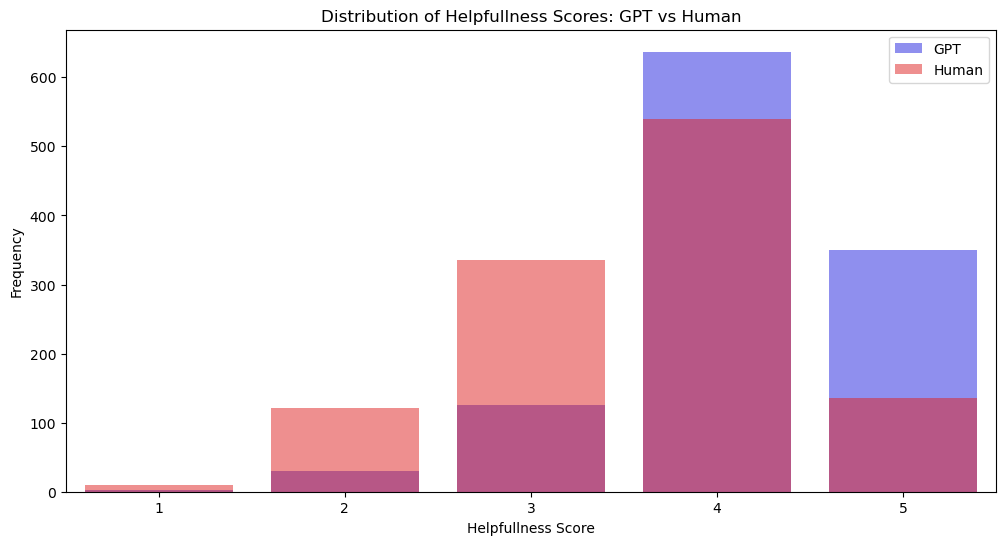

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create frequency distributions
gpt_freq = df[df['chatgpt'] == True]['hjelpsomhet'].value_counts().sort_index()
human_freq = df[df['chatgpt'] == False]['hjelpsomhet'].value_counts().sort_index()

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.barplot(x=gpt_freq.index, y=gpt_freq.values, alpha=0.5, color='blue', label='GPT')
sns.barplot(x=human_freq.index, y=human_freq.values, alpha=0.5, color='red', label='Human')
plt.title('Distribution of Helpfullness Scores: GPT vs Human')
plt.xlabel('Helpfullness Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

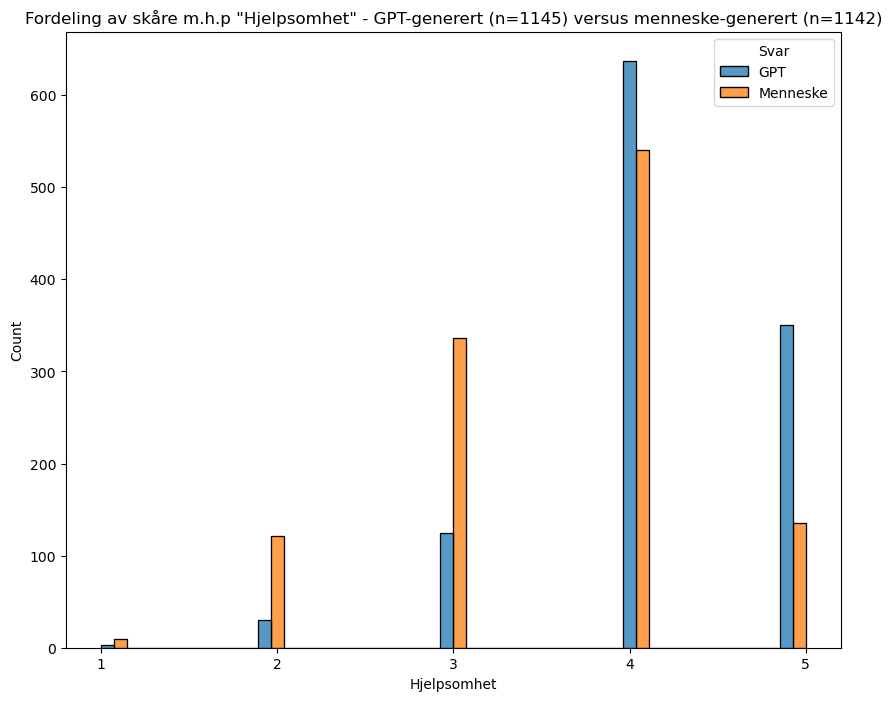

In [42]:
# Plot the distribution of the scores for "hjelpsomhet" -  GPT versus human

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT[['hjelpsomhet']].assign(Svar='GPT'), df_human[['hjelpsomhet']].assign(Svar='Menneske')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='hjelpsomhet', hue='Svar', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 6, 1))

plt.xlabel('Hjelpsomhet')
plt.title(f'Fordeling av skåre m.h.p "Hjelpsomhet" - GPT-generert (n={len(df_GPT)}) versus menneske-generert (n={len(df_human)})')


plt.show()

Investigate Which Score Categories Contribute Most to the Observed Difference:

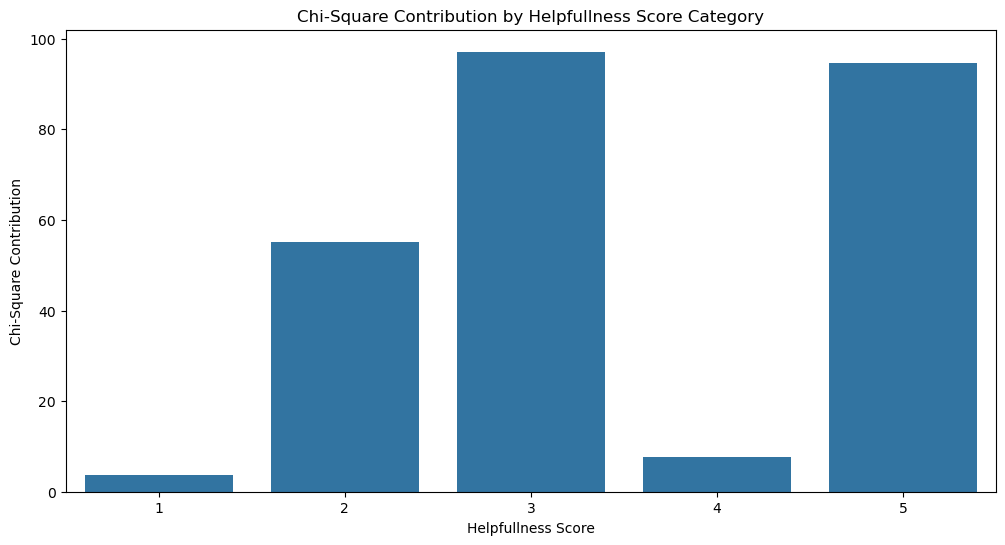

In [43]:
# Calculate the expected frequencies
total = len(df)
gpt_total = len(df[df['chatgpt'] == True])
human_total = len(df[df['chatgpt'] == False])

expected_gpt = gpt_total * (gpt_freq + human_freq) / total
expected_human = human_total * (gpt_freq + human_freq) / total

# Calculate chi-square contribution for each category
chi_square_contrib = ((gpt_freq - expected_gpt)**2 / expected_gpt + 
                      (human_freq - expected_human)**2 / expected_human)

# Plot the chi-square contributions
plt.figure(figsize=(12, 6))
sns.barplot(x=chi_square_contrib.index, y=chi_square_contrib.values)
plt.title('Chi-Square Contribution by Helpfullness Score Category')
plt.xlabel('Helpfullness Score')
plt.ylabel('Chi-Square Contribution')
plt.show()

Explore Factors Leading to Different Distributions:

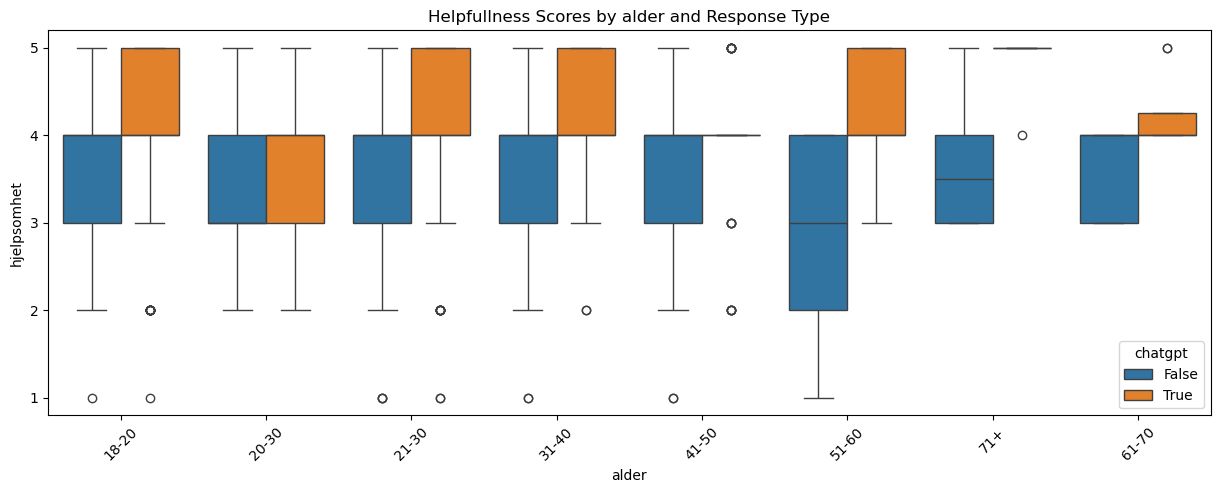

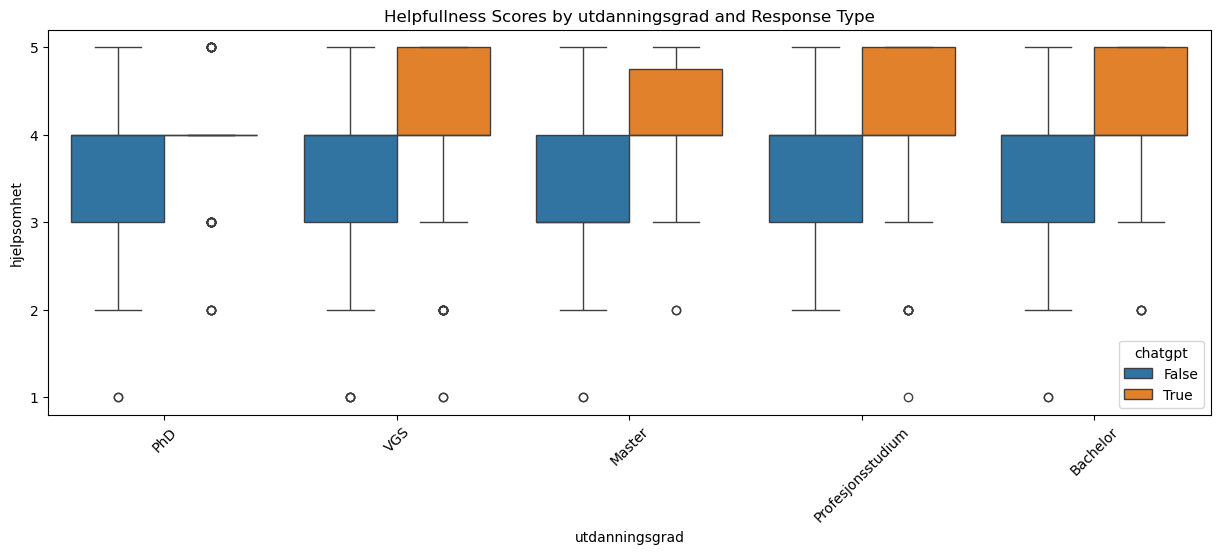

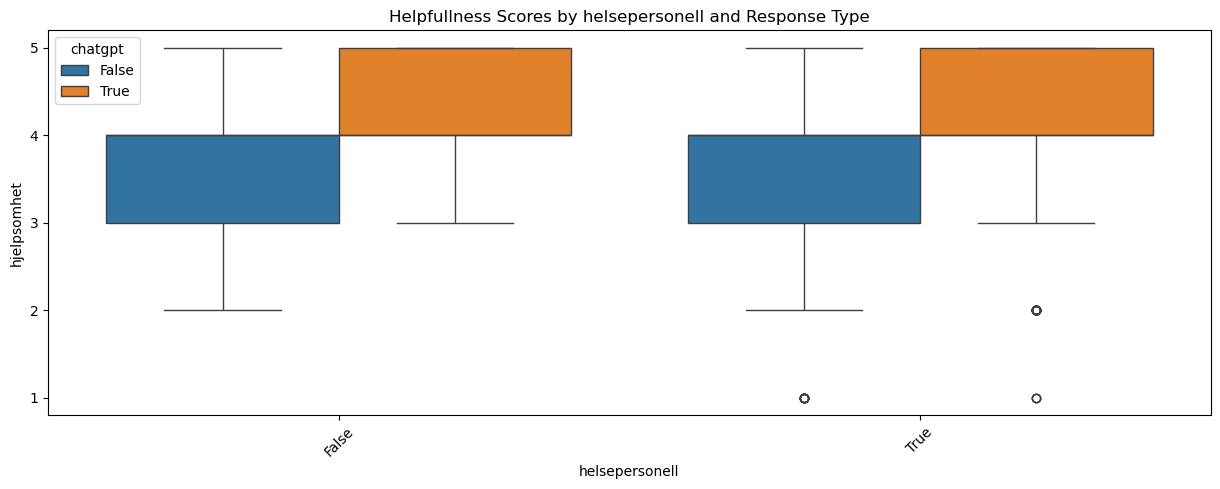

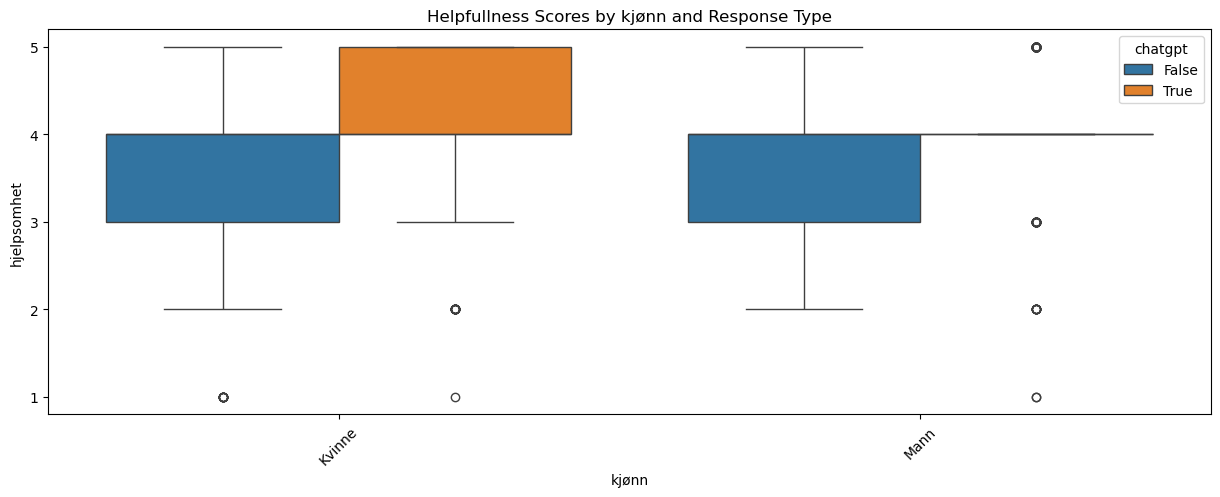

In [44]:
# Analyze by respondent characteristics
factors = ['alder', 'utdanningsgrad', 'helsepersonell', 'kjønn']

for factor in factors:
    plt.figure(figsize=(15, 5))
    sns.boxplot(x=factor, y='hjelpsomhet', hue='chatgpt', data=df)
    plt.title(f'Helpfullness Scores by {factor} and Response Type')
     # yticks
    plt.yticks(np.arange(1, 6, 1))
    plt.xticks(rotation=45)
    plt.show()

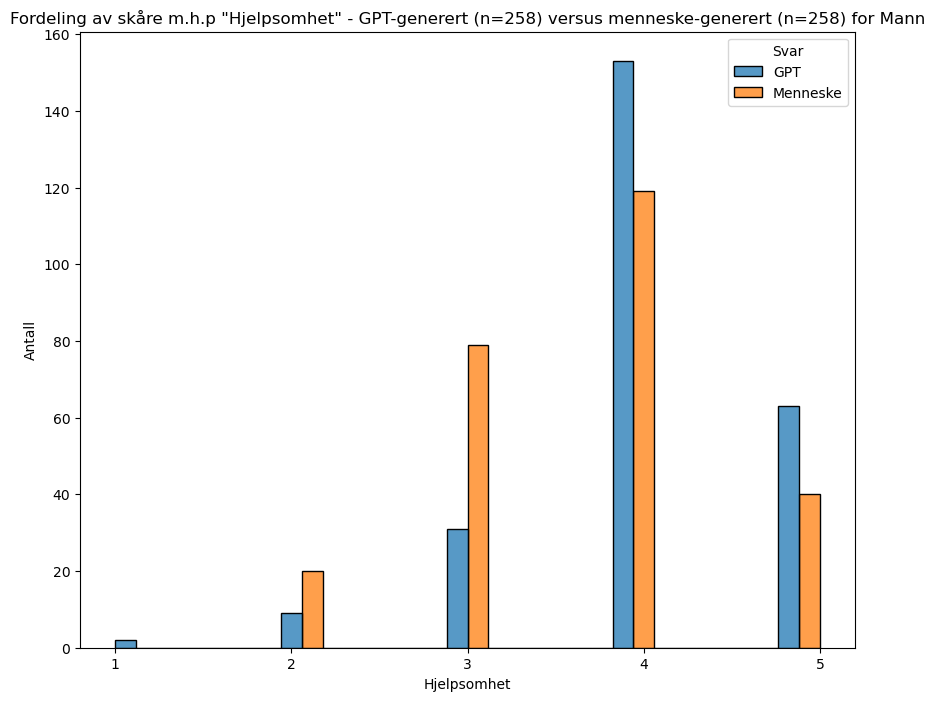

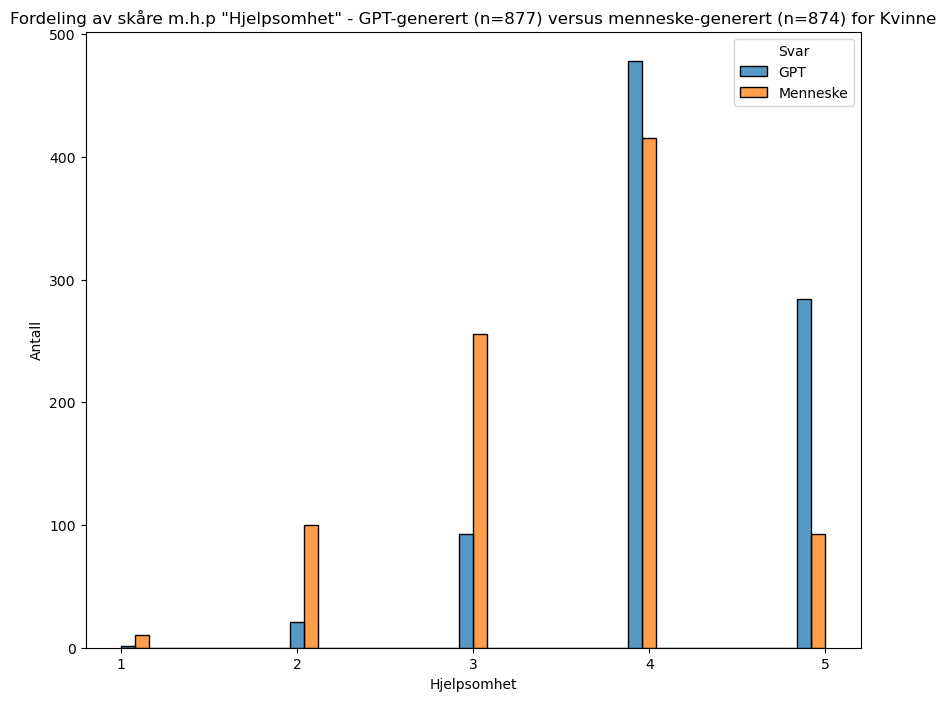

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define a function to create the plot for a specific gender
def plot_helpfullness_distribution(df_GPT, df_human, gender):
    # Filter the dataframes for the specified gender
    df_GPT_gender = df_GPT[df_GPT['kjønn'] == gender]
    df_human_gender = df_human[df_human['kjønn'] == gender]
    
    fig, ax = plt.subplots(figsize=(10, 8))

    # Combine the data into a single DataFrame
    df_combined = pd.concat([df_GPT_gender[['hjelpsomhet']].assign(Svar='GPT'), 
                             df_human_gender[['hjelpsomhet']].assign(Svar='Menneske')])

    # Plot the histograms side by side
    sns.histplot(data=df_combined, x='hjelpsomhet', hue='Svar', multiple='dodge')

    # Make the x-ticks integers centered between the two bars
    plt.xticks(np.arange(1, 6, 1))

    plt.xlabel('Hjelpsomhet')
    plt.ylabel('Antall')
    plt.title(f'Fordeling av skåre m.h.p "Hjelpsomhet" - GPT-generert (n={len(df_GPT_gender)}) versus menneske-generert (n={len(df_human_gender)}) for {gender}')

    plt.show()

# Create plots for men and women
plot_helpfullness_distribution(df_GPT, df_human, 'Mann')
plot_helpfullness_distribution(df_GPT, df_human, 'Kvinne')

In [46]:
import numpy as np
from scipy import stats

# Function to calculate summary statistics
def summarize_helpfullness(df, group):
    return df[df['chatgpt'] == group]['hjelpsomhet'].agg(['mean', 'median', 'std']).to_dict()

# Summarize empathy scores
male_gpt = summarize_helpfullness(df[df['kjønn'] == 'Mann'], True)
male_human = summarize_helpfullness(df[df['kjønn'] == 'Mann'], False)
female_gpt = summarize_helpfullness(df[df['kjønn'] == 'Kvinne'], True)
female_human = summarize_helpfullness(df[df['kjønn'] == 'Kvinne'], False)

print("Male GPT:", male_gpt)
print("Male Human:", male_human)
print("Female GPT:", female_gpt)
print("Female Human:", female_human)

# Perform Mann-Whitney U tests
def mann_whitney_test(df, gender):
    gpt_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == True)]['hjelpsomhet']
    human_scores = df[(df['kjønn'] == gender) & (df['chatgpt'] == False)]['hjelpsomhet']
    return stats.mannwhitneyu(gpt_scores, human_scores, alternative='two-sided')

male_stat, male_p = mann_whitney_test(df, 'Mann')
female_stat, female_p = mann_whitney_test(df, 'Kvinne')

print("\nMann-Whitney U test results:")
print(f"Male: statistic={male_stat}, p-value={male_p}")
print(f"Female: statistic={female_stat}, p-value={female_p}")

# Test for interaction effect
def interaction_test(df):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    df['group'] = df.apply(lambda row: f"{'GPT' if row['chatgpt'] else 'Human'}_{row['kjønn']}", axis=1)
    tukey = pairwise_tukeyhsd(df['hjelpsomhet'], df['group'])
    return tukey

tukey_results = interaction_test(df)
print("\nTukey HSD test results:")
print(tukey_results)

Male GPT: {'mean': 4.0310077519379846, 'median': 4.0, 'std': 0.7582283722804847}
Male Human: {'mean': 3.693798449612403, 'median': 4.0, 'std': 0.8247392643502618}
Female GPT: {'mean': 4.166476624857468, 'median': 4.0, 'std': 0.7132906674157354}
Female Human: {'mean': 3.5503432494279177, 'median': 4.0, 'std': 0.8709942818268075}

Mann-Whitney U test results:
Male: statistic=41179.0, p-value=3.3834872121105195e-07
Female: statistic=532542.0, p-value=6.060251134719616e-53

Tukey HSD test results:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
  GPT_Kvinne     GPT_Mann  -0.1355 0.1543  -0.296  0.0251  False
  GPT_Kvinne      GPT_nan   0.0335    1.0 -0.6874  0.7545  False
  GPT_Kvinne Human_Kvinne  -0.6161    0.0 -0.7245 -0.5078   True
  GPT_Kvinne   Human_Mann  -0.4727    0.0 -0.6332 -0.3121   True
  GPT_Kvinne    Human_nan  -0.2665 0.8993 -0.9

La oss oppsummere og forklare de viktigste funnene:

1. Generell oversikt:
   - Totalt antall vurderinger: 2287
   - GPT-genererte svar: 1145
   - Menneskegenererte svar: 1142

2. Kunnskap:
   - Median score for GPT: 5.0
   - Median score for mennesker: 4.0
   - Chi-square test: p-verdi = 3.24e-42 (statistisk signifikant forskjell)
   - Mann-Whitney U-test: p-verdi = 2.40e-45 (statistisk signifikant forskjell)
   - Gjennomsnittlig score (ekskludert "Vet ikke"):
     GPT: 4.37 ± 0.79
     Mennesker: 3.86 ± 0.99

   Tolkning: GPT-genererte svar ble vurdert som signifikant mer kunnskapsrike enn menneskegenererte svar.

3. Empati:
   - Median score for GPT: 4.0
   - Median score for mennesker: 3.0
   - Chi-square test: p-verdi = 2.57e-122 (statistisk signifikant forskjell)
   - Mann-Whitney U-test: p-verdi = 1.11e-122 (statistisk signifikant forskjell)

   Tolkning: GPT-genererte svar ble vurdert som signifikant mer empatiske enn menneskegenererte svar.

4. Hjelpsomhet:
   - Median score for både GPT og mennesker: 4.0
   - Chi-square test: p-verdi = 9.67e-55 (statistisk signifikant forskjell)
   - Mann-Whitney U-test: p-verdi = 4.17e-57 (statistisk signifikant forskjell)
   - Gjennomsnittlig score:
     GPT: 4.14 ± 0.72
     Mennesker: 3.59 ± 0.86

   Tolkning: Selv om medianscoren er lik, viser testene en signifikant forskjell i fordelingen av scores. GPT-genererte svar ble generelt vurdert som mer hjelpsomme.

5. Kjønnsforskjeller:
   - Både menn og kvinner vurderte GPT-svar høyere på empati og hjelpsomhet.
   - Forskjellen mellom GPT og menneskelige svar var større for kvinner enn for menn.

6. Helsepersonell vs. ikke-helsepersonell:
   - Ingen signifikant forskjell i hvordan helsepersonell og ikke-helsepersonell vurderte kunnskapen i GPT-svar (p = 0.16).

7. Andre demografiske faktorer:
   - Alder, utdanningsnivå og kjønn viste noen signifikante forskjeller i vurderingene, men effekten var mindre uttalt enn forskjellen mellom GPT og menneskelige svar.

Hovedkonklusjoner:
1. GPT-genererte svar ble konsekvent vurdert som mer kunnskapsrike, empatiske og hjelpsomme enn menneskegenererte svar.
2. Forskjellen i vurderinger mellom GPT og menneskelige svar var mer uttalt for kvinnelige respondenter.
3. Helsepersonell og ikke-helsepersonell hadde lignende vurderinger av GPT-svarenes kunnskap.
4. Demografiske faktorer som alder og utdanningsnivå hadde noen effekter på vurderingene, men disse var mindre betydningsfulle enn forskjellen mellom GPT og menneskelige svar.

Disse funnene reiser interessante spørsmål om hvordan AI-genererte svar oppfattes i helsekontekster, og kan ha implikasjoner for fremtidig bruk av AI i helsekommunikasjon og pasientrådgivning.

Statistical Tests for Factor Influence:

In [47]:
from scipy.stats import chi2_contingency

def chi_square_test(df, factor):
    contingency_table = pd.crosstab(df[factor], [df['chatgpt'], df['hjelpsomhet']])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {factor}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"p-value: {p}")
    print("---")

for factor in factors:
    chi_square_test(df, factor)

Chi-square test for alder:
Chi-square statistic: 119.72670283340085
p-value: 2.154778866451646e-05
---
Chi-square test for utdanningsgrad:
Chi-square statistic: 62.937928347030635
p-value: 0.0035988953830751445
---
Chi-square test for helsepersonell:
Chi-square statistic: 2.3318518131830346
p-value: 0.9850689939297292
---
Chi-square test for kjønn:
Chi-square statistic: 19.242873804451925
p-value: 0.02320518508117492
---


La oss analysere hver faktor og dens betydning for vurderingen av hjelpsomhet i svarene:

1. Alder:
   Chi-square statistic: 119.72670283340085
   p-value: 2.154778866451646e-05

   Tolkning:
   - P-verdien er svært lav (p < 0.05), noe som indikerer en statistisk signifikant sammenheng mellom alder og vurdering av hjelpsomhet.
   - Dette betyr at ulike aldersgrupper har en tendens til å vurdere hjelpsomheten i svarene forskjellig.

   Implikasjoner:
   - Alder spiller en viktig rolle i hvordan personer oppfatter og vurderer hjelpsomheten i svar, enten de er generert av GPT eller mennesker.
   - Det kan være nødvendig å tilpasse kommunikasjonsstrategier for ulike aldersgrupper i helsevesenet.
   - Videre forskning bør undersøke hvordan og hvorfor ulike aldersgrupper vurderer hjelpsomhet forskjellig.

2. Utdanningsgrad:
   Chi-square statistic: 62.937928347030635
   p-value: 0.0035988953830751445

   Tolkning:
   - P-verdien er under 0.05, noe som indikerer en statistisk signifikant sammenheng mellom utdanningsnivå og vurdering av hjelpsomhet.
   - Dette antyder at personer med ulik utdanningsbakgrunn har en tendens til å vurdere hjelpsomheten i svarene forskjellig.

   Implikasjoner:
   - Utdanningsnivå påvirker hvordan personer oppfatter og vurderer hjelpsomheten i helserelaterte svar.
   - Dette kan ha betydning for hvordan helseinformasjon bør kommuniseres til ulike grupper i samfunnet.
   - Det kan være behov for å tilpasse kommunikasjonsstrategier basert på målgruppens utdanningsnivå.

3. Helsepersonell:
   Chi-square statistic: 2.3318518131830346
   p-value: 0.9850689939297292

   Tolkning:
   - P-verdien er svært høy (p > 0.05), noe som indikerer at det ikke er en statistisk signifikant sammenheng mellom helsepersonellstatus og vurdering av hjelpsomhet.
   - Dette betyr at helsepersonell og ikke-helsepersonell generelt vurderer hjelpsomheten i svarene på lignende måter.

   Implikasjoner:
   - Helsepersonellstatus ser ikke ut til å påvirke vurderingen av hjelpsomhet i betydelig grad.
   - Dette kan tyde på at GPT-genererte svar og menneskelige svar oppfattes som like hjelpsomme (eller uhjelpsomme) av både helsepersonell og ikke-helsepersonell.
   - Det kan indikere at AI-genererte svar potensielt kan være nyttige for både fagfolk og pasienter.

4. Kjønn:
   Chi-square statistic: 19.242873804451925
   p-value: 0.02320518508117492

   Tolkning:
   - P-verdien er under 0.05, noe som indikerer en statistisk signifikant sammenheng mellom kjønn og vurdering av hjelpsomhet.
   - Dette betyr at menn og kvinner har en tendens til å vurdere hjelpsomheten i svarene noe forskjellig.

   Implikasjoner:
   - Kjønnsforskjeller spiller en rolle i hvordan hjelpsomhet oppfattes i helserelaterte svar.
   - Dette kan ha betydning for hvordan helseinformasjon bør kommuniseres til ulike kjønn.
   - Videre forskning bør undersøke årsakene til disse kjønnsforskjellene og hvordan de kan adresseres i helsekommunikasjon.

Samlet diskusjon:

Disse resultatene viser at demografiske faktorer som alder, utdanningsnivå og kjønn har en signifikant innvirkning på hvordan personer vurderer hjelpsomheten i helserelaterte svar, enten de er generert av AI eller mennesker. Dette har flere viktige implikasjoner:

1. Persontilpasnng av helsekommunikasjon: Det kan være nødvendig å tilpasse kommunikasjonsstrategier basert på målgruppens alder, utdanningsnivå og kjønn for å maksimere oppfattelsen av hjelpsomhet.

2. AI-utvikling: Ved utvikling av AI-systemer for helsekommunikasjon bør man ta hensyn til disse demografiske faktorene for å sikre at svarene oppfattes som hjelpsomme av ulike grupper.

3. Opplæring av helsepersonell: Helsepersonell bør være oppmerksomme på hvordan ulike demografiske grupper kan oppfatte hjelpsomhet forskjellig, og tilpasse sin kommunikasjon deretter.

4. Likhet i helsevesenet: Forskjellene i oppfattet hjelpsomhet basert på demografiske faktorer kan potensielt føre til ulikheter i helseutfall. Dette bør adresseres for å sikre likeverdig tilgang til nyttig helseinformasjon.

5. Videre forskning: Det er behov for mer detaljerte studier for å forstå de underliggende årsakene til disse forskjellene og hvordan de best kan adresseres i helsekommunikasjon.

6. Universell design: Til tross for forskjellene, bør målet være å utvikle kommunikasjonsstrategier og AI-systemer som er universelt hjelpsomme, uavhengig av demografiske faktorer.

Avslutningsvis er det verdt å merke seg at selv om disse demografiske faktorene er signifikante, ser helsepersonellstatus ut til å ha minimal innvirkning på vurderingen av hjelpsomhet. Dette kan tyde på at AI-genererte svar har potensial til å være nyttige på tvers av ulike nivåer av helsekompetanse.

### Hypotese 4 som undersøkes (mhp. df1) er følgende:

**Respondent kategori** :<br>
H0: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmål som _like_ kunnskapsrike som hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør i vurderingen av Chat-GPT 4.0 sine svar mhp. kunnskap.<br>
H1: leger og medisinstudenter med lisens vurderer Chat-GPT 4.0 sine svar på kliniske spørsmå til å ha _ulik_ grad av kunnskap sammenliknet med hva andre som jobber/ studerer eller har bakgrunn i helsevesenet gjør.

In [48]:
# df_GPT_MD = df_GPT[df_GPT['helsepersonell'] == True]
# df_GPT_nonMD = df_GPT[df_GPT['helsepersonell'] == False]

df_GPT_MD = df_GPT[df_GPT['harlisens'] == True]
df_GPT_nonMD = df_GPT[df_GPT['harlisens'] == False]

print(f'len(df_GPT_MD)={len(df_GPT_MD)}, len(df_GPT_nonMD)={len(df_GPT_nonMD)}')

len(df_GPT_MD)=170, len(df_GPT_nonMD)=975


In [49]:
# Make new dataframes df_GPT_MD_kunnskap_excl6 and df_GPT_nonMD_kunnskap_excl6 where kunnskap is not 6

df_GPT_MD_kunnskap_excl6 = df_GPT_MD[df_GPT_MD['kunnskap'] != 6]
df_GPT_nonMD_kunnskap_excl6 = df_GPT_nonMD[df_GPT_nonMD['kunnskap'] != 6]

print(f'len(df_GPT_MD_kunnskap_excl6)={len(df_GPT_MD_kunnskap_excl6)}, len(df_GPT_nonMD_kunnskap_excl6)={len(df_GPT_nonMD_kunnskap_excl6)}')    


len(df_GPT_MD_kunnskap_excl6)=169, len(df_GPT_nonMD_kunnskap_excl6)=925


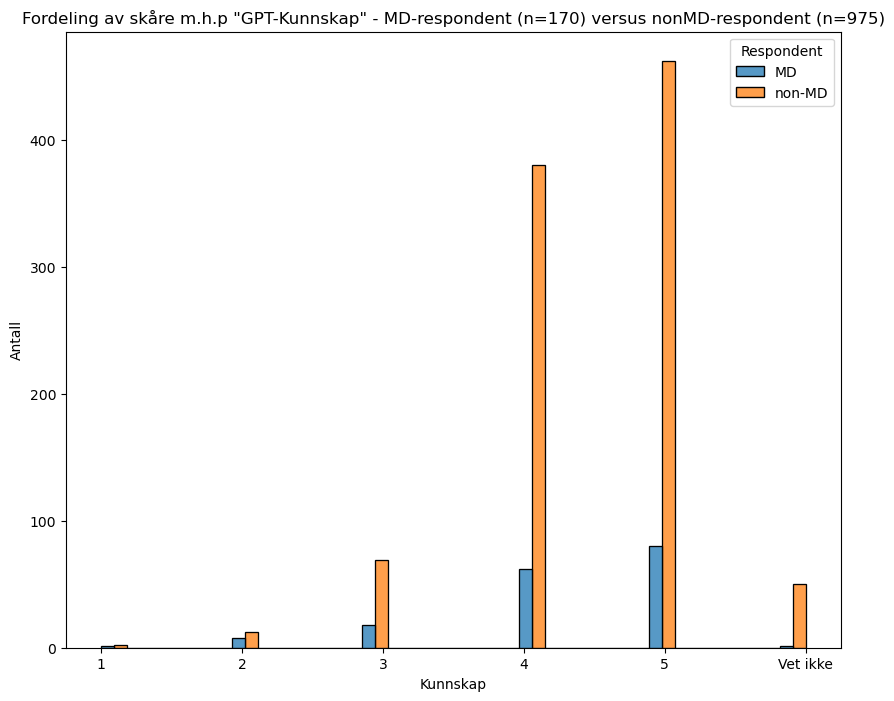

In [50]:
# Plot the distribution of the scores for GPT "kunnskap" -  MD versus nonMD

fig, ax = plt.subplots(figsize=(10, 8))

# Combine the data into a single DataFrame
df_combined = pd.concat([df_GPT_MD[['kunnskap']].assign(Respondent='MD'), df_GPT_nonMD[['kunnskap']].assign(Respondent='non-MD')])

# Plot the histograms side by side
sns.histplot(data=df_combined, x='kunnskap', hue='Respondent', multiple='dodge')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

plt.xlabel('Kunnskap')
plt.ylabel('Antall')
plt.title(f'Fordeling av skåre m.h.p "GPT-Kunnskap" - MD-respondent (n={len(df_GPT_MD)}) versus nonMD-respondent (n={len(df_GPT_nonMD)})')

# Make the x-ticks integers centerd between the two bars
plt.xticks(np.arange(1, 7, 1))

# Assuming 'plt' is the current plot
ticks, labels = plt.xticks()  # Get current x-axis tick labels

# Find the index of the tick mark 6
index = list(ticks).index(6)

# Replace the label at the index with 'Vet ikke'
labels[index] = 'Vet ikke'

plt.xticks(ticks, labels)  # Set new x-axis tick labels


plt.show()

In [51]:
# Test the following hypothesis: H0: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are the same 
# vs. H1: The distribution of the scores regarding GPT's kunnskap: MD vs. non-MD and are different (MD's scores are likely lower)

# Perform the Mann-Whitney U test
stat, p = mannwhitneyu(df_GPT_MD_kunnskap_excl6['kunnskap'], df_GPT_nonMD_kunnskap_excl6['kunnskap'])
print(f'stat={stat}, p={p}')

# Interpret the p-value
alpha = 0.05

if p > alpha:
    print('Samme fordeling (kan ikke forkaste H0)')
else:
    print('Forskjellig fordeling (forkast H0)')

print(f'($n_{{GPT_MD}}$ = {len(df_GPT_MD_kunnskap_excl6)}, $n_{{GPT_nonMD}}$ = {len(df_GPT_nonMD_kunnskap_excl6)})')

stat=73384.0, p=0.16033145626526613
Samme fordeling (kan ikke forkaste H0)
($n_{GPT_MD}$ = 169, $n_{GPT_nonMD}$ = 925)


In [52]:
# How large is the difference in the mean scores of GPT-kunnskap for MDs vs. non-MDs?

mean_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].mean()
mean_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].mean()

std_MD = df_GPT_MD_kunnskap_excl6['kunnskap'].std()
std_nonMD = df_GPT_nonMD_kunnskap_excl6['kunnskap'].std()

diff = mean_MD - mean_nonMD
print(f'Mean score for GPT-kunnskap for MDs: {mean_MD:.2f} std={std_MD:.2f} (n={len(df_GPT_MD)})')
print(f'Mean score for GPT-kunnskap for non-MDs: {mean_nonMD:.2f} std={std_nonMD:.2f} (n={len(df_GPT_nonMD)})')
print(f'Difference in mean scores: {diff:.2f}')

Mean score for GPT-kunnskap for MDs: 4.25 std=0.87 (n=170)
Mean score for GPT-kunnskap for non-MDs: 4.39 std=0.70 (n=975)
Difference in mean scores: -0.14


### Back to original data frame

In [53]:
df[:2].T

,0,1
vurderingid,1,4
respondentid,6,7
svarid,1,1
kunnskap,3,2
empati,4,4
hjelpsomhet,4,3
alder,18-20,18-20
utdanningsgrad,PhD,PhD
helsepersonell,True,True
harlisens,False,False


In [54]:
# Write df[:2].T as LateX table


print(df[:2].T.to_latex(index=True, formatters={"name": str.upper}, bold_rows=True, float_format="{:.1f}".format)) # , file=open('table.tex', 'w'))

\begin{tabular}{lll}
\toprule
 & 0 & 1 \\
\midrule
\textbf{vurderingid} & 1 & 4 \\
\textbf{respondentid} & 6 & 7 \\
\textbf{svarid} & 1 & 1 \\
\textbf{kunnskap} & 3 & 2 \\
\textbf{empati} & 4 & 4 \\
\textbf{hjelpsomhet} & 4 & 3 \\
\textbf{alder} & 18-20 & 18-20 \\
\textbf{utdanningsgrad} & PhD & PhD \\
\textbf{helsepersonell} & True & True \\
\textbf{harlisens} & False & False \\
\textbf{kjønn} & Kvinne & Kvinne \\
\textbf{svartfør} & False & False \\
\textbf{fylke} & Vestland & Vestland \\
\textbf{dato} & 2024-01-15T10:39:13.805Z & 2024-01-15T10:39:27.752Z \\
\textbf{spørsmålid} & 1 & 1 \\
\textbf{chatgpt} & False & False \\
\textbf{svartekst} & Takk for spørsmålet ditt! Jeg skal være ærlig på at dette er ikke mitt ekspertområdet og måtte gjøre et lite artikkelsøk før jeg kunne svare deg. Det jeg kunne lese fra en studie utført av FHI (folkehelseinstituttet) er at de mener at inntak av små flak av teflon belegg regnes ikke å ha noe signifikant helsefare. Det jeg også kunne lese er at 

In [55]:
df[-2:].T

,2285,2286
vurderingid,2265,2266
respondentid,635,635
svarid,393,392
kunnskap,4,4
empati,4,4
hjelpsomhet,4,4
alder,21-30,21-30
utdanningsgrad,Bachelor,Bachelor
helsepersonell,True,True
harlisens,False,False


# Compare human versus GPT

**Ideas for questions to ask:**

1. Comparison of Performance: How do the evaluation scores differ between humans and GPT in terms of knowledge, empathy, and helpfulness? This question aims to identify specific areas where one might outperform the other.

2. Score Correlation Analysis: Is there a correlation between the scores assigned to human responses and those assigned to GPT responses across the same questions? Understanding this could reveal if perceptions towards humans and GPT are consistent across respondents.

3. Impact of Healthcare Profession: How does being a healthcare professional influence the evaluation of human versus GPT responses? This could help identify if professional experience affects the perception of accuracy or empathy in responses.

4. Influence of Gender: Does the respondent's gender have an impact on the scoring of human and GPT responses? This question seeks to uncover if there are gender-based biases in evaluating responses.

5. Age-Related Differences: How does the age of respondents affect their evaluation of human versus GPT responses? Age could influence familiarity with technology or expectations of empathy, thus affecting scores.

6. Educational Level's Effect: What role does the educational background play in scoring human and GPT responses? This could highlight if higher education correlates with a critical evaluation of responses.

7. Inter-Criteria Correlation: Is there a significant correlation between the scores on the criteria of knowledge, helpfulness, and empathy? This question aims to understand if high scores in one area tend to coincide with high scores in others, indicating a general positive or negative bias.

8. Textual Analysis for Themes and Sentiments: What common themes, words, or phrases emerge from the response texts, and how do sentiments differ between GPT and human responses? This analysis could reveal underlying patterns in what is valued in responses or how certain topics are approached differently by humans and GPT.

In [56]:
len(df)

2287

In [57]:
# Get value.count sorted on 'kunnskap', 'empati', 'hjelepsomhet' for which chatgpt is True
subset_df = df[df['chatgpt'] == True]
items = ['kunnskap', 'empati', 'hjelpsomhet']
for item in items: 
    value_counts = subset_df[item].value_counts().sort_values(ascending=False)
    print(f'chatgp ({item}): \n{value_counts}')


chatgp (kunnskap): 
kunnskap
5    542
4    442
3     87
6     51
2     20
1      3
Name: count, dtype: int64
chatgp (empati): 
empati
4    595
5    341
3    171
2     37
1      1
Name: count, dtype: int64
chatgp (hjelpsomhet): 
hjelpsomhet
4    637
5    350
3    125
2     30
1      3
Name: count, dtype: int64


In [58]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)

print(nested_table)


     chatgpt  kunnskap  empati  hjelpsomhet  counts
108     True         4       4            4     227
126     True         5       5            5     195
122     True         5       4            4     170
41     False         4       3            4     152
44     False         4       4            4     103
..       ...       ...     ...          ...     ...
105     True         4       3            5       1
120     True         5       4            2       1
127     True         6       2            4       1
128     True         6       3            1       1
134     True         6       5            3       1

[137 rows x 5 columns]


In [59]:
items = ['kunnskap', 'empati', 'hjelpsomhet']
nested_table = df.groupby(['chatgpt'] + items).size().reset_index(name='counts')

# To sort the table
nested_table = nested_table.sort_values(by='counts', ascending=False)
sorted_table = nested_table.sort_values(by=['chatgpt']+items)

sorted_table

,chatgpt,kunnskap,empati,hjelpsomhet,counts
0,False,1,1,1,5
1,False,1,3,2,1
2,False,2,1,2,10
3,False,2,1,3,1
4,False,2,2,2,26
...,...,...,...,...,...
132,True,6,4,4,21
133,True,6,4,5,3
134,True,6,5,3,1
135,True,6,5,4,4


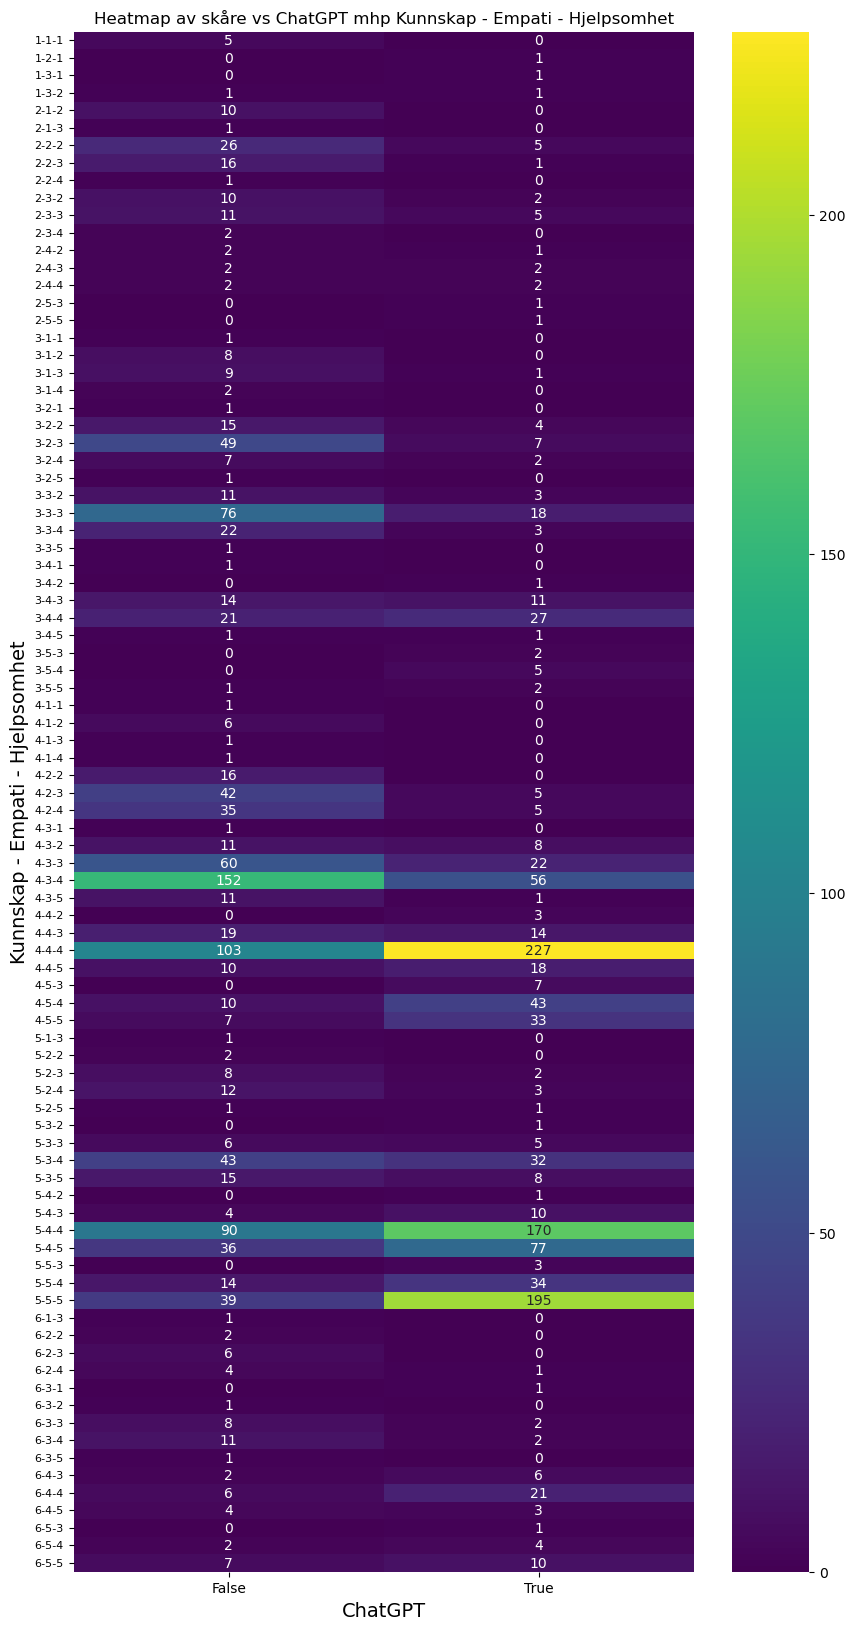

In [60]:
# A heatmap to illustrate the effect of chatgpt True or False on the structure of the sorted_table across items

import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the table
pivot_table = sorted_table.pivot_table(values='counts', index=items, columns='chatgpt', fill_value=0)

# Create the heatmap
plt.figure(figsize=(10, 20))  # Increase figure size
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis', yticklabels=True)

figtitle = f'Heatmap av skåre vs ChatGPT mhp {items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}'
plt.title(figtitle)
plt.yticks(fontsize=8)  # Decrease y-tick label font size
plt.ylabel(f'{items[0].capitalize()} - {items[1].capitalize()} - {items[2].capitalize()}', fontsize=14)
plt.xlabel(f'ChatGPT', fontsize=14)

plt.show()

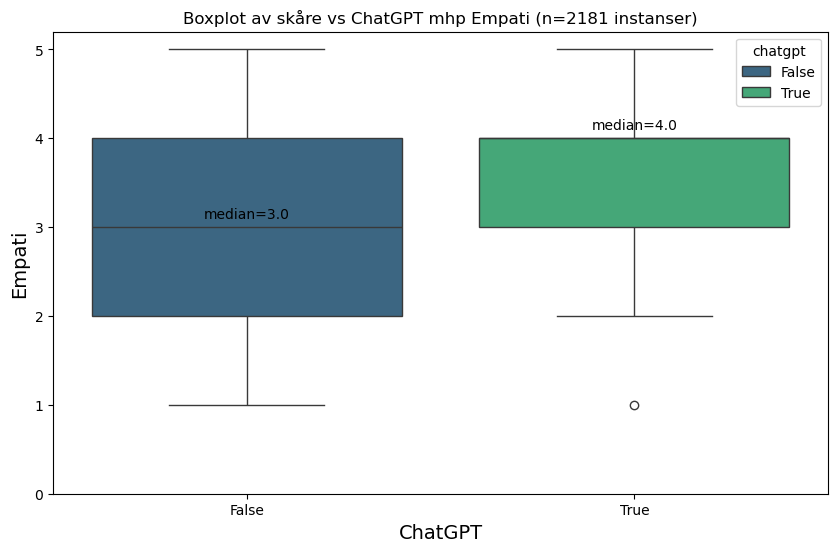

In [61]:
# Plot score distribution on 'empati' grouped by 'chatgpt'

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create the boxplot
plt.figure(figsize=(10, 6))  # Increase figure size
sns.boxplot(data=sorted_table, x='chatgpt', y='empati', hue='chatgpt', palette='viridis')

# Integer ticks on y-axis
plt.yticks(np.arange(0, 6, 1))

figtitle = f'Boxplot av skåre vs ChatGPT mhp Empati (n={len(df1)} instanser)'
plt.title(figtitle)
plt.ylabel('Empati', fontsize=14)
plt.xlabel('ChatGPT', fontsize=14)

# Add median values across all instances for each chatgpt group in the legend text
medians = sorted_table.groupby(['chatgpt'])['empati'].median()
median_labels = [str(np.round(s, 2)) for s in medians]
pos = range(len(medians))
for tick, label in zip(pos, plt.gca().get_xticklabels()):
    plt.text(pos[tick], medians.iloc[tick] + 0.1, f'median={median_labels[tick]}', 
             horizontalalignment='center', size=10, color='black', weight='normal')

plt.show()

In [62]:
df['empati'].value_counts()

empati
4    912
3    625
5    421
2    281
1     48
Name: count, dtype: int64

In [63]:
df['hjelpsomhet'].value_counts()

hjelpsomhet
4    1177
5     485
3     461
2     151
1      13
Name: count, dtype: int64

In [64]:
df.groupby('chatgpt')['kunnskap'].mean()

chatgpt
False    3.961471
True     4.443668
Name: kunnskap, dtype: float64

In [65]:
df.groupby('chatgpt')['kunnskap'].std()

chatgpt
False    0.989119
True     0.790357
Name: kunnskap, dtype: float64

In [66]:
# Function to generate a correlation heatmap
def correlation_heatmap(df, savefig=False):
    corr = df[['kunnskap', 'empati', 'hjelpsomhet']].corr()
    plt.figure(figsize=(15, 5))  
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

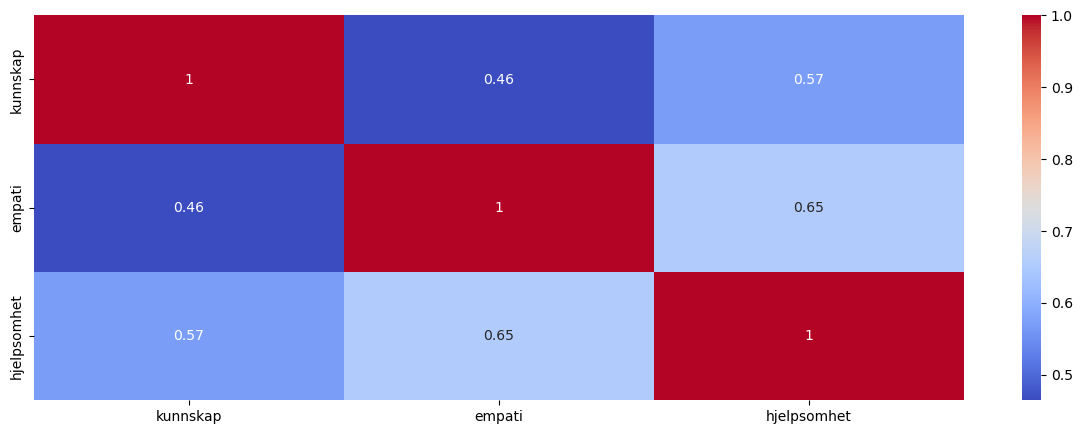

In [67]:
correlation_heatmap(df, savefig=False)

In [68]:
from wordcloud import WordCloud

# Function to generate a wordcloud
def generate_wordcloud(df, high=True):
    if high:
        text = ' '.join(df[df['kunnskap'] > 3]['svartekst'])
    else:
        text = ' '.join(df[df['kunnskap'] <= 3]['svartekst'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(15, 5))  
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

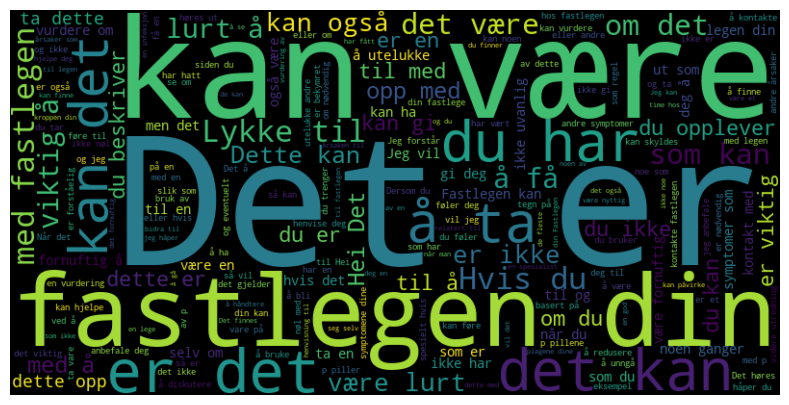

In [69]:
generate_wordcloud(df, high=True)